Importing the libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

Data Loading and intial Analysis

In [3]:
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Load the dataset
df = pd.read_csv('/content/Character.csv')

print("Dataset loaded successfully!")
print(f"Shape: {df.shape}")
print("\nFirst few rows:")
print(df.head())
print("\nDataset Info:")
print(df.info())
print("\nColumn names:")
print(df.columns.tolist())

Dataset loaded successfully!
Shape: (1442, 3)

First few rows:
                                         Description    Verdict  \
0  The ambitious and tyrannical King of England, ...        Bad   
1  Henry's devout and dignified first wife, whom ...       Good   
2  The captivating and ambitious lady-in-waiting ...  Ambiguous   
3  A powerful, corrupt, and ambitious churchman w...        Bad   
4  The narrator and protagonist, a fiercely indep...       Good   

                Character  
0         King Henry VIII  
1         Queen Katherine  
2             Anne Boleyn  
3         Cardinal Wolsey  
4  Tribulation Periwinkle  

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1442 entries, 0 to 1441
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Description  1442 non-null   object
 1   Verdict      1442 non-null   object
 2   Character    1442 non-null   object
dtypes: object(3)
memory usage: 33.9+ KB

Data Analysis

INITIAL DATA ANALYSIS

Missing Values:
Description    0
Verdict        0
Character      0
dtype: int64

Data Types:
Description    object
Verdict        object
Character      object
dtype: object

Basic Statistics:
                                              Description Verdict  \
count                                                1442    1442   
unique                                               1442       7   
top     The courier's wife, who receives an anonymous ...    Good   
freq                                                    1     783   

              Character  
count              1442  
unique             1376  
top     Sherlock Holmes  
freq                  5  

Verdict Distribution (Original):
Verdict
Good                         783
Bad                          350
Ambiguous                    168
Neutral                      134
Bad (Situation)                4
Tragic                         2
Good (for comedic effect)      1
Name: count, dtype: int64


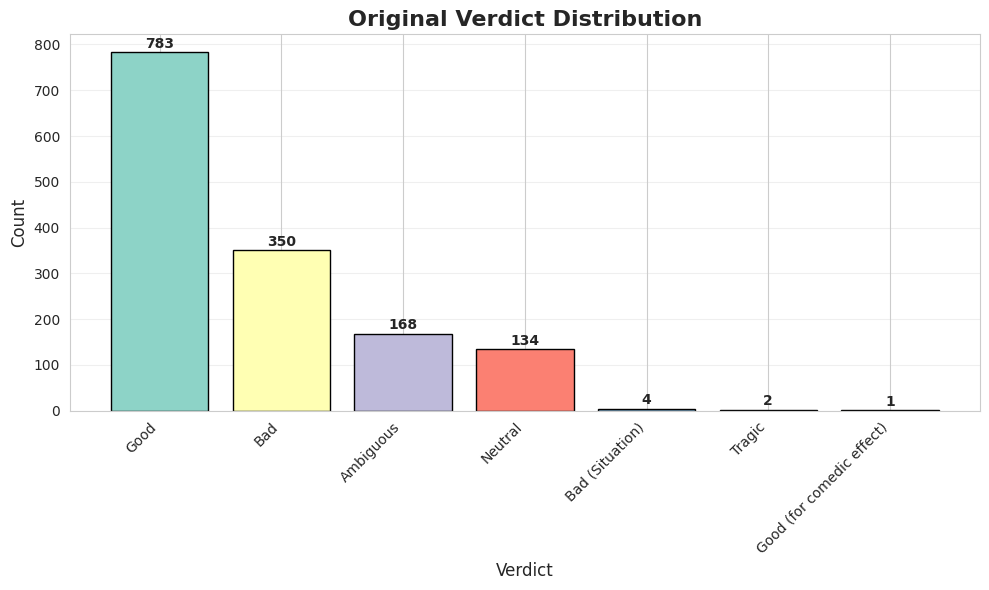

In [4]:
print("="*80)
print("INITIAL DATA ANALYSIS")
print("="*80)

# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())

# Check data types
print("\nData Types:")
print(df.dtypes)

# Basic statistics
print("\nBasic Statistics:")
print(df.describe(include='all'))

# Verdict distribution (before processing)
print("\nVerdict Distribution (Original):")
print(df['Verdict'].value_counts())

# Visualize original verdict distribution
plt.figure(figsize=(10, 6))
verdict_counts = df['Verdict'].value_counts()
colors = plt.cm.Set3(range(len(verdict_counts)))
plt.bar(verdict_counts.index, verdict_counts.values, color=colors, edgecolor='black')
plt.title('Original Verdict Distribution', fontsize=16, fontweight='bold')
plt.xlabel('Verdict', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
for i, v in enumerate(verdict_counts.values):
    plt.text(i, v + 10, str(v), ha='center', fontweight='bold')
plt.tight_layout()
plt.show()

Data Pre-processing


DATA PREPROCESSING

Rows before removing missing values: 1442
Rows after removing missing values: 1442

Rows before cleaning unmapped values: 1442
Rows after cleaning unmapped values: 1274

Verdict Distribution (After Processing):
Verdict
Good    786
Bad     488
Name: count, dtype: int64

Number of duplicate rows: 0


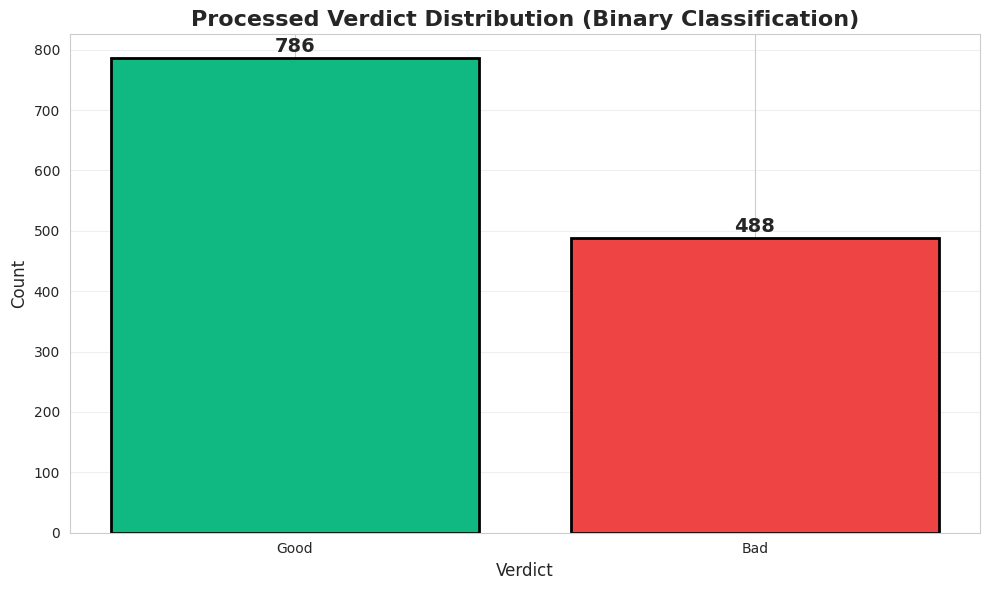


Text Statistics:
       text_length   word_count
count  1274.000000  1274.000000
mean    128.256672    20.235479
std      21.042826     3.590526
min      41.000000     6.000000
25%     115.000000    18.000000
50%     128.000000    20.000000
75%     142.000000    23.000000
max     194.000000    32.000000


In [5]:
print("\n" + "="*80)
print("DATA PREPROCESSING")
print("="*80)

# Create a copy of the dataframe
df_processed = df.copy()

# Remove rows with missing values
print(f"\nRows before removing missing values: {len(df_processed)}")
df_processed = df_processed.dropna()
print(f"Rows after removing missing values: {len(df_processed)}")

# Apply the verdict mapping as per requirements
verdict_mapping = {
    'Neutral': 'Bad',  # Neutral as ambiguous Bad
    'Bad (Situation)': 'Bad',  # Bad (Situation) as bad only
    'Tragic': 'Good',  # Tragic as Good only
    'Good (for comedic effect)': 'Good',  # Good (for comedic effect) as Good only
    'Good': 'Good',
    'Bad': 'Bad'
}

df_processed['Verdict'] = df_processed['Verdict'].map(verdict_mapping)

# Remove any rows that don't map correctly
print(f"\nRows before cleaning unmapped values: {len(df_processed)}")
df_processed = df_processed[df_processed['Verdict'].notna()]
print(f"Rows after cleaning unmapped values: {len(df_processed)}")

print("\nVerdict Distribution (After Processing):")
print(df_processed['Verdict'].value_counts())

# Check for duplicates
duplicates = df_processed.duplicated().sum()
print(f"\nNumber of duplicate rows: {duplicates}")
if duplicates > 0:
    df_processed = df_processed.drop_duplicates()
    print(f"Rows after removing duplicates: {len(df_processed)}")

# Visualize processed verdict distribution
plt.figure(figsize=(10, 6))
verdict_counts_processed = df_processed['Verdict'].value_counts()
colors = ['#10b981', '#ef4444']
plt.bar(verdict_counts_processed.index, verdict_counts_processed.values, color=colors, edgecolor='black', linewidth=2)
plt.title('Processed Verdict Distribution (Binary Classification)', fontsize=16, fontweight='bold')
plt.xlabel('Verdict', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.grid(axis='y', alpha=0.3)
for i, v in enumerate(verdict_counts_processed.values):
    plt.text(i, v + 10, str(v), ha='center', fontweight='bold', fontsize=14)
plt.tight_layout()
plt.show()

# Text length analysis
df_processed['text_length'] = df_processed['Description'].apply(len)
df_processed['word_count'] = df_processed['Description'].apply(lambda x: len(str(x).split()))

print("\nText Statistics:")
print(df_processed[['text_length', 'word_count']].describe())

In [6]:
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
import nltk

# Download required NLTK data
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('punkt', quiet=True)

def preprocess_text(text):
    """
    Comprehensive text preprocessing function
    """
    # Convert to lowercase
    text = str(text).lower()

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Remove email addresses
    text = re.sub(r'\S+@\S+', '', text)

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Remove extra whitespace
    text = ' '.join(text.split())

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in stop_words])

    return text

# Apply preprocessing
print("\nApplying text preprocessing...")
df_processed['cleaned_description'] = df_processed['Description'].apply(preprocess_text)

print("\nExample of preprocessing:")
print(f"Original: {df_processed['Description'].iloc[0][:100]}...")
print(f"Cleaned: {df_processed['cleaned_description'].iloc[0][:100]}...")


Applying text preprocessing...

Example of preprocessing:
Original: The ambitious and tyrannical King of England, driven by his desire for a male heir and absolute powe...
Cleaned: ambitious tyrannical king england driven desire male heir absolute power...


Feature Engineering


FEATURE ENGINEERING

Target Classes: ['Bad' 'Good']
Encoded as: {'Bad': np.int64(0), 'Good': np.int64(1)}

Training set size: 1019
Test set size: 255

Creating TF-IDF features...
TF-IDF Feature shape: (1019, 2391)

Creating Count Vectorizer features...
Count Vectorizer Feature shape: (1019, 2391)


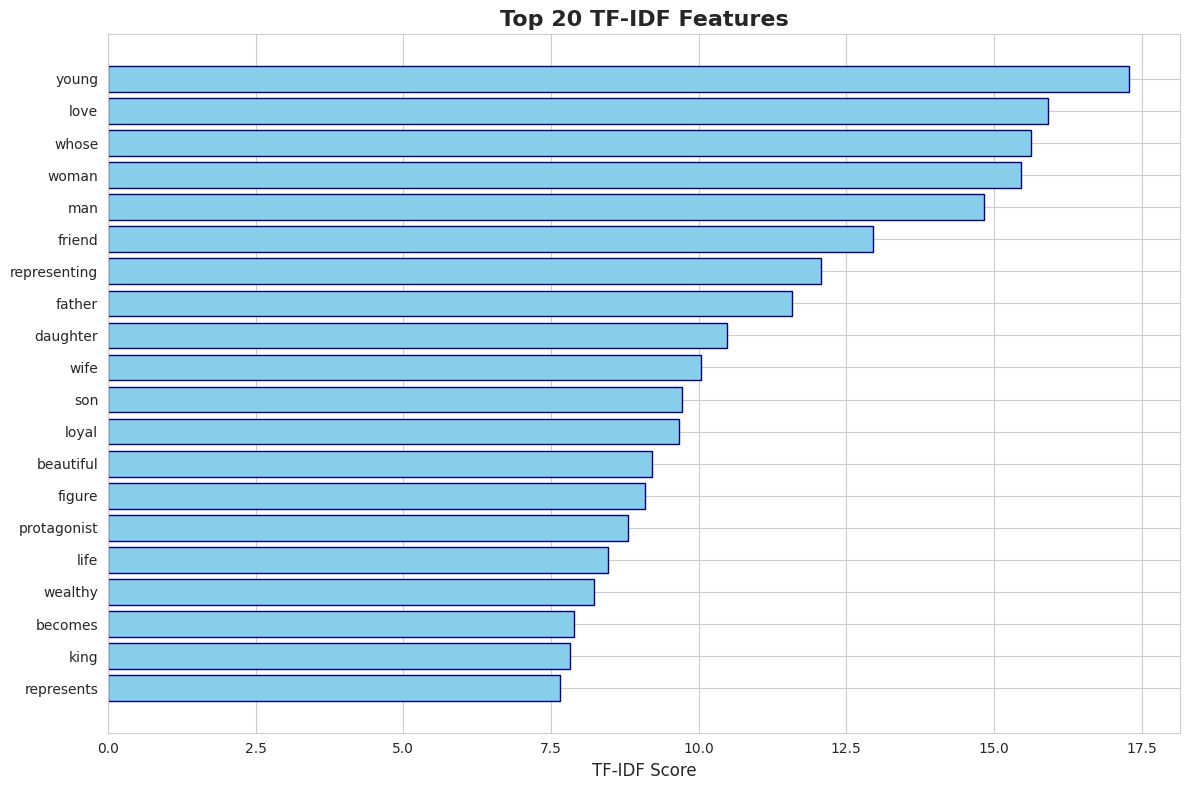

In [7]:
print("\n" + "="*80)
print("FEATURE ENGINEERING")
print("="*80)

# Prepare features and target
X = df_processed['cleaned_description']
y = df_processed['Verdict']

# Encode target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print(f"\nTarget Classes: {label_encoder.classes_}")
print(f"Encoded as: {dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))}")

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"\nTraining set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

# TF-IDF Vectorization
print("\nCreating TF-IDF features...")
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,
    min_df=2,
    max_df=0.8,
    ngram_range=(1, 2)
)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(f"TF-IDF Feature shape: {X_train_tfidf.shape}")

# Count Vectorization (for Naive Bayes)
print("\nCreating Count Vectorizer features...")
count_vectorizer = CountVectorizer(
    max_features=5000,
    min_df=2,
    max_df=0.8,
    ngram_range=(1, 2)
)

X_train_count = count_vectorizer.fit_transform(X_train)
X_test_count = count_vectorizer.transform(X_test)

print(f"Count Vectorizer Feature shape: {X_train_count.shape}")

# Visualize feature importance (top TF-IDF terms)
feature_names = tfidf_vectorizer.get_feature_names_out()
tfidf_scores = X_train_tfidf.sum(axis=0).A1
top_features_idx = tfidf_scores.argsort()[-20:][::-1]
top_features = [feature_names[i] for i in top_features_idx]
top_scores = [tfidf_scores[i] for i in top_features_idx]

plt.figure(figsize=(12, 8))
plt.barh(range(len(top_features)), top_scores, color='skyblue', edgecolor='navy')
plt.yticks(range(len(top_features)), top_features)
plt.xlabel('TF-IDF Score', fontsize=12)
plt.title('Top 20 TF-IDF Features', fontsize=16, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

Logistic Regression


MODEL 1: LOGISTIC REGRESSION

Training Logistic Regression...

Logistic Regression Results:
Accuracy: 0.7176

Classification Report:
              precision    recall  f1-score   support

         Bad       0.82      0.34      0.48        98
        Good       0.70      0.96      0.81       157

    accuracy                           0.72       255
   macro avg       0.76      0.65      0.64       255
weighted avg       0.75      0.72      0.68       255


Cross-Validation Scores: [0.68137255 0.65196078 0.70098039 0.70098039 0.70935961]
Mean CV Accuracy: 0.6889 (+/- 0.0413)


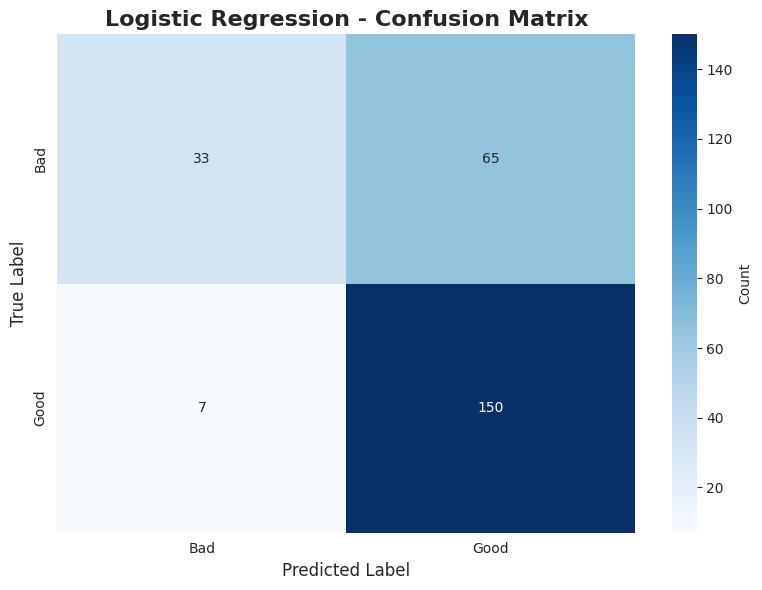

In [8]:
print("\n" + "="*80)
print("MODEL 1: LOGISTIC REGRESSION")
print("="*80)

# Train Logistic Regression
print("\nTraining Logistic Regression...")
lr_model = LogisticRegression(max_iter=1000, random_state=42, C=1.0)
lr_model.fit(X_train_tfidf, y_train)

# Predictions
y_pred_lr = lr_model.predict(X_test_tfidf)



# Evaluation
print("\nLogistic Regression Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_lr):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr, target_names=label_encoder.classes_))

# Cross-validation
cv_scores_lr = cross_val_score(lr_model, X_train_tfidf, y_train, cv=5, scoring='accuracy')
print(f"\nCross-Validation Scores: {cv_scores_lr}")
print(f"Mean CV Accuracy: {cv_scores_lr.mean():.4f} (+/- {cv_scores_lr.std() * 2:.4f})")

# Confusion Matrix
cm_lr = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_, cbar_kws={'label': 'Count'})
plt.title('Logistic Regression - Confusion Matrix', fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

MULTINOMIAL NAIVE BAYES


MODEL 2: MULTINOMIAL NAIVE BAYES

Training Multinomial Naive Bayes...

Multinomial Naive Bayes Results:
Accuracy: 0.8118

Classification Report:
              precision    recall  f1-score   support

         Bad       0.78      0.71      0.74        98
        Good       0.83      0.87      0.85       157

    accuracy                           0.81       255
   macro avg       0.80      0.79      0.80       255
weighted avg       0.81      0.81      0.81       255


Cross-Validation Scores: [0.71568627 0.74509804 0.76470588 0.78431373 0.77832512]
Mean CV Accuracy: 0.7576 (+/- 0.0499)


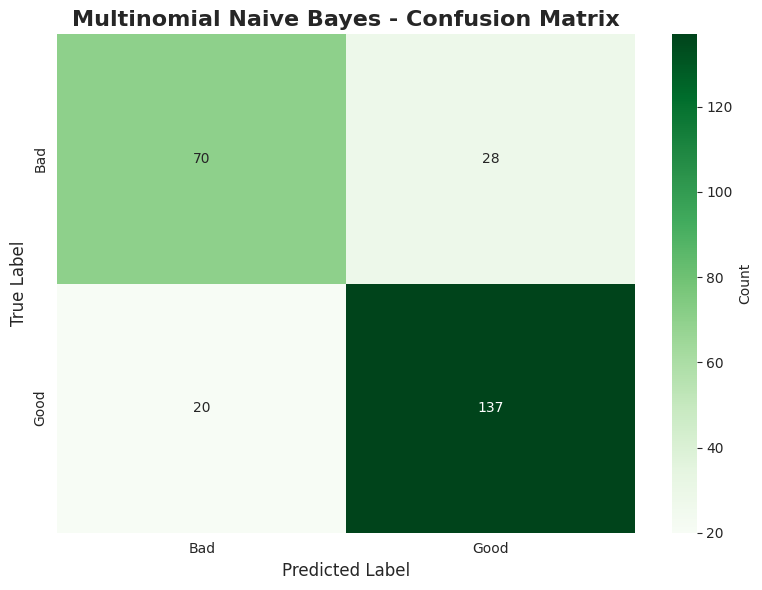

In [9]:
print("\n" + "="*80)
print("MODEL 2: MULTINOMIAL NAIVE BAYES")
print("="*80)

# Train Multinomial Naive Bayes
print("\nTraining Multinomial Naive Bayes...")
nb_model = MultinomialNB(alpha=1.0)
nb_model.fit(X_train_count, y_train)

# Predictions
y_pred_nb = nb_model.predict(X_test_count)

# Evaluation
print("\nMultinomial Naive Bayes Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_nb):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_nb, target_names=label_encoder.classes_))

# Cross-validation
cv_scores_nb = cross_val_score(nb_model, X_train_count, y_train, cv=5, scoring='accuracy')
print(f"\nCross-Validation Scores: {cv_scores_nb}")
print(f"Mean CV Accuracy: {cv_scores_nb.mean():.4f} (+/- {cv_scores_nb.std() * 2:.4f})")

# Confusion Matrix
cm_nb = confusion_matrix(y_test, y_pred_nb)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Greens', xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_, cbar_kws={'label': 'Count'})
plt.title('Multinomial Naive Bayes - Confusion Matrix', fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

SUPPORT VECTOR MACHINE


MODEL 3: SUPPORT VECTOR MACHINE

Training SVM (this may take a while)...

SVM Results:
Accuracy: 0.8000

Classification Report:
              precision    recall  f1-score   support

         Bad       0.78      0.66      0.72        98
        Good       0.81      0.89      0.84       157

    accuracy                           0.80       255
   macro avg       0.80      0.77      0.78       255
weighted avg       0.80      0.80      0.80       255


Cross-Validation Scores: [0.67647059 0.71078431 0.72058824 0.74509804 0.77339901]
Mean CV Accuracy: 0.7253 (+/- 0.0653)


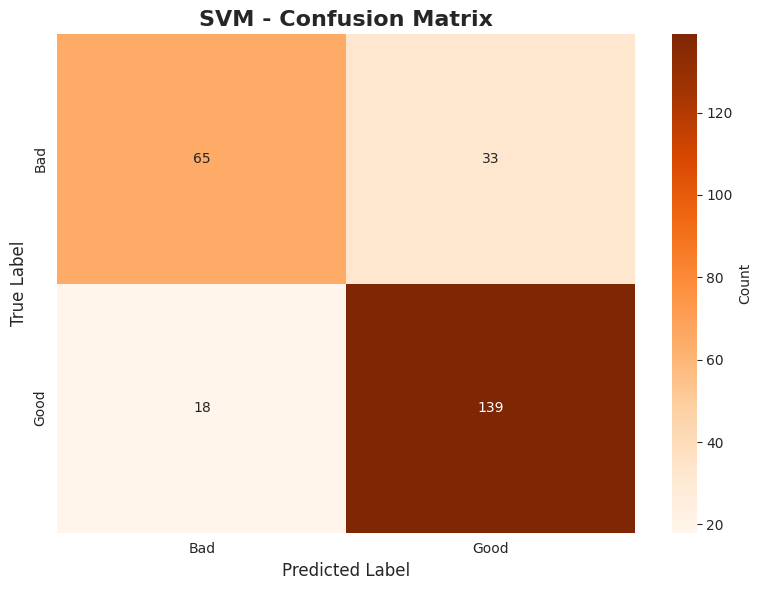

In [10]:
print("\n" + "="*80)
print("MODEL 3: SUPPORT VECTOR MACHINE")
print("="*80)

# Train SVM
print("\nTraining SVM (this may take a while)...")
svm_model = SVC(kernel='linear', C=1.0, random_state=42, probability=True)
svm_model.fit(X_train_tfidf, y_train)

# Predictions
y_pred_svm = svm_model.predict(X_test_tfidf)

# Evaluation
print("\nSVM Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_svm):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_svm, target_names=label_encoder.classes_))

# Cross-validation
cv_scores_svm = cross_val_score(svm_model, X_train_tfidf, y_train, cv=5, scoring='accuracy')
print(f"\nCross-Validation Scores: {cv_scores_svm}")
print(f"Mean CV Accuracy: {cv_scores_svm.mean():.4f} (+/- {cv_scores_svm.std() * 2:.4f})")

# Confusion Matrix
cm_svm = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Oranges', xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_, cbar_kws={'label': 'Count'})
plt.title('SVM - Confusion Matrix', fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

RANDOM FOREST


MODEL 4: RANDOM FOREST (REGULARIZED)

Training Random Forest...

Random Forest Results:
Accuracy: 0.7333

Classification Report:
              precision    recall  f1-score   support

         Bad       0.61      0.85      0.71        98
        Good       0.87      0.66      0.75       157

    accuracy                           0.73       255
   macro avg       0.74      0.75      0.73       255
weighted avg       0.77      0.73      0.74       255


Cross-Validation Scores: [0.62254902 0.67156863 0.69117647 0.67647059 0.64039409]
Mean CV Accuracy: 0.6604 (+/- 0.0503)


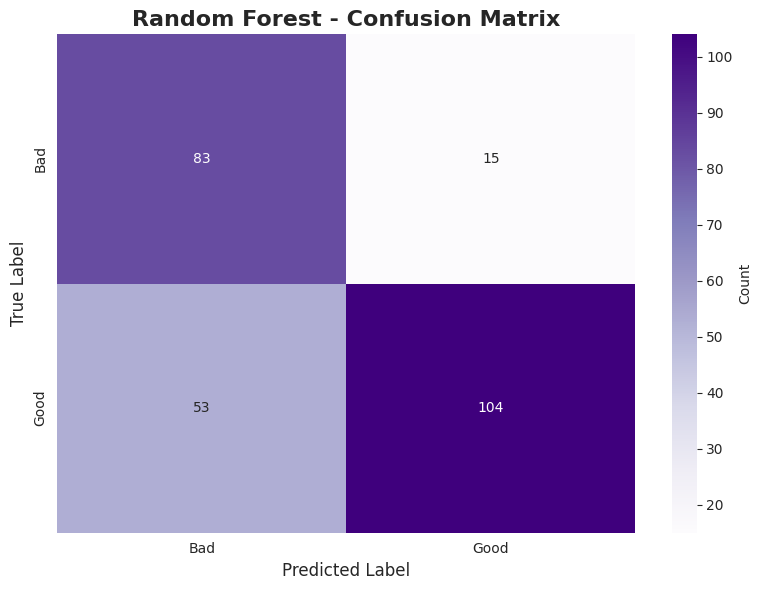

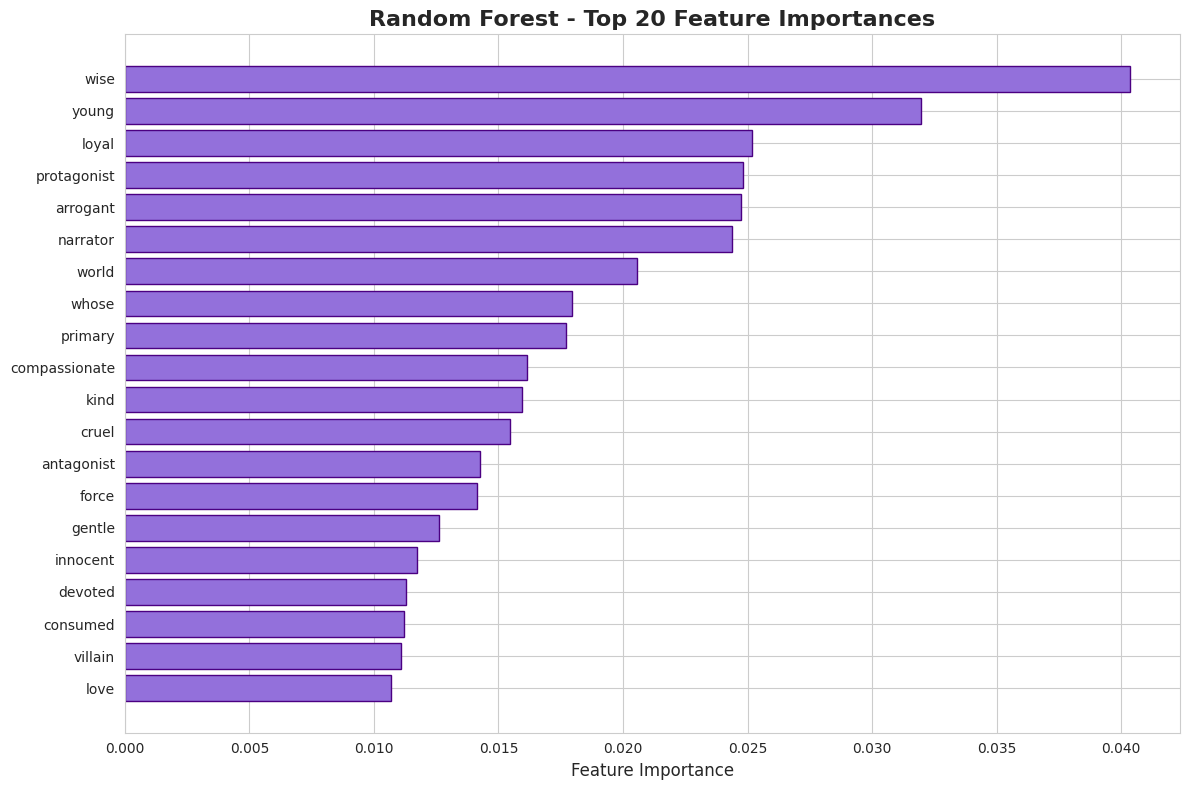

In [11]:
print("\n" + "="*80)
print("MODEL 4: RANDOM FOREST (REGULARIZED)")
print("="*80)


print("\nTraining Random Forest...")
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=10,  # Require more samples to split
    min_samples_leaf=5,  # Require more samples in leaf nodes
    max_features='sqrt',  # Use sqrt of features for each split
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'  # Handle class imbalance
)
rf_model.fit(X_train_tfidf, y_train)

# Predictions
y_pred_rf = rf_model.predict(X_test_tfidf)
y_pred_rf_train = rf_model.predict(X_train_tfidf)

# Evaluation
print("\nRandom Forest Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf, target_names=label_encoder.classes_))

# Cross-validation
cv_scores_rf = cross_val_score(rf_model, X_train_tfidf, y_train, cv=5, scoring='accuracy')
print(f"\nCross-Validation Scores: {cv_scores_rf}")
print(f"Mean CV Accuracy: {cv_scores_rf.mean():.4f} (+/- {cv_scores_rf.std() * 2:.4f})")

# Confusion Matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Purples', xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_, cbar_kws={'label': 'Count'})
plt.title('Random Forest - Confusion Matrix', fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

# Feature Importance
feature_importance = rf_model.feature_importances_
top_indices = feature_importance.argsort()[-20:][::-1]
top_features_rf = [feature_names[i] for i in top_indices]
top_importance = [feature_importance[i] for i in top_indices]

plt.figure(figsize=(12, 8))
plt.barh(range(len(top_features_rf)), top_importance, color='mediumpurple', edgecolor='indigo')
plt.yticks(range(len(top_features_rf)), top_features_rf)
plt.xlabel('Feature Importance', fontsize=12)
plt.title('Random Forest - Top 20 Feature Importances', fontsize=16, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

GRADIENT BOOSTING


MODEL 5: GRADIENT BOOSTING

Training Gradient Boosting...

Gradient Boosting Results:
Accuracy: 0.7373

Classification Report:
              precision    recall  f1-score   support

         Bad       0.75      0.48      0.58        98
        Good       0.73      0.90      0.81       157

    accuracy                           0.74       255
   macro avg       0.74      0.69      0.70       255
weighted avg       0.74      0.74      0.72       255


Cross-Validation Scores: [0.66176471 0.65686275 0.70098039 0.66666667 0.71428571]
Mean CV Accuracy: 0.6801 (+/- 0.0461)


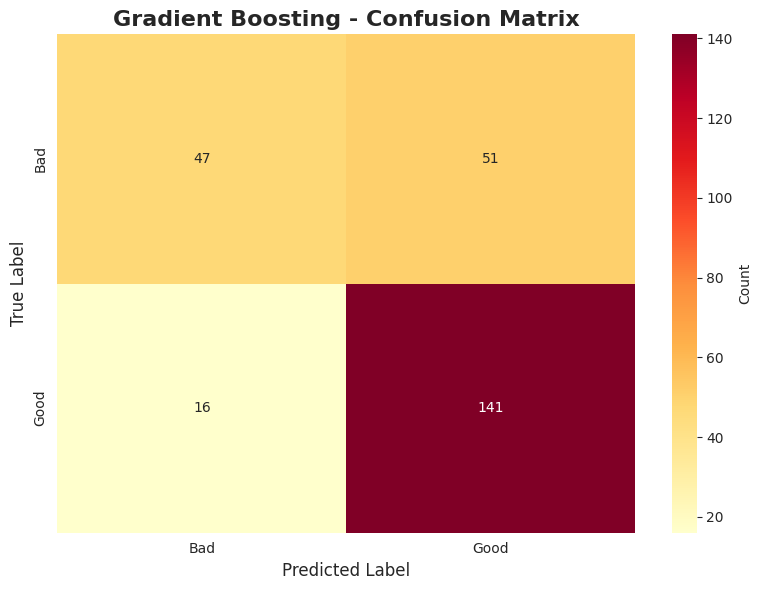

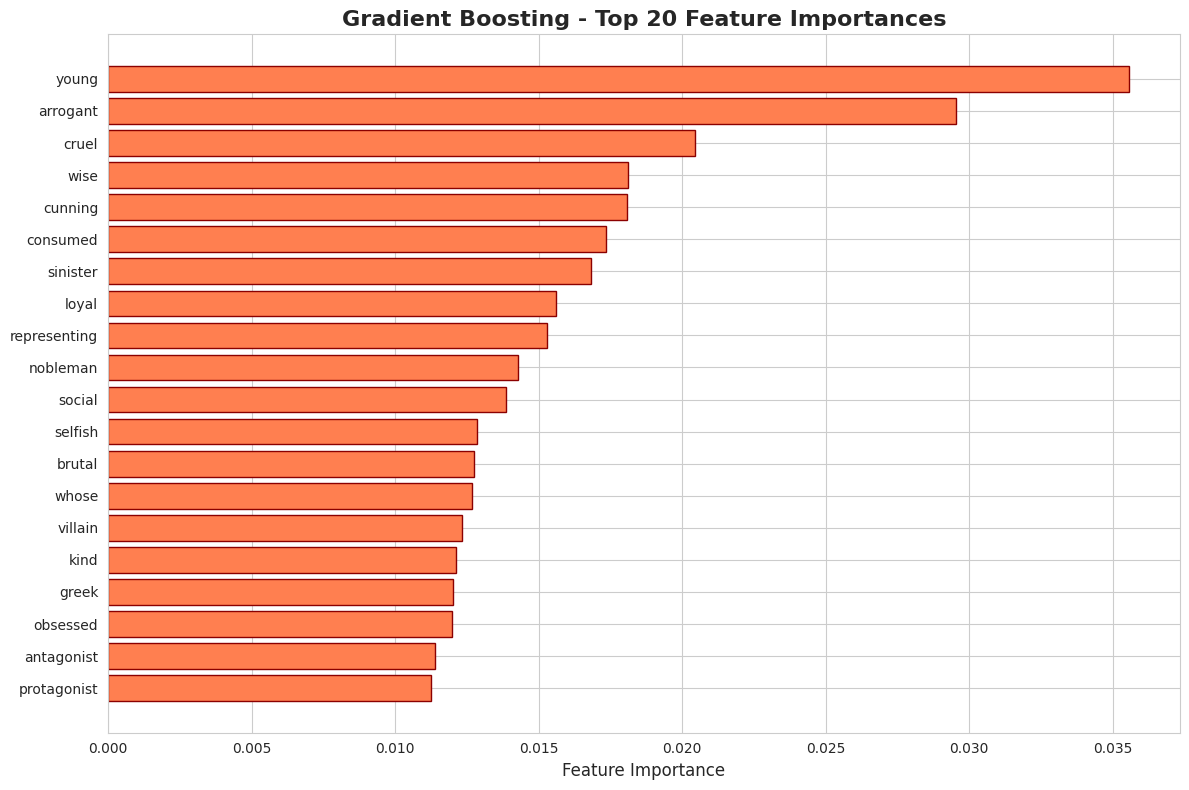

In [12]:
print("\n" + "="*80)
print("MODEL 5: GRADIENT BOOSTING")
print("="*80)

# Train Gradient Boosting
print("\nTraining Gradient Boosting...")
gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
gb_model.fit(X_train_tfidf, y_train)

# Predictions
y_pred_gb = gb_model.predict(X_test_tfidf)

# Evaluation
print("\nGradient Boosting Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_gb):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_gb, target_names=label_encoder.classes_))

# Cross-validation
cv_scores_gb = cross_val_score(gb_model, X_train_tfidf, y_train, cv=5, scoring='accuracy')
print(f"\nCross-Validation Scores: {cv_scores_gb}")
print(f"Mean CV Accuracy: {cv_scores_gb.mean():.4f} (+/- {cv_scores_gb.std() * 2:.4f})")

# Confusion Matrix
cm_gb = confusion_matrix(y_test, y_pred_gb)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_gb, annot=True, fmt='d', cmap='YlOrRd', xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_, cbar_kws={'label': 'Count'})
plt.title('Gradient Boosting - Confusion Matrix', fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

# Feature Importance
feature_importance_gb = gb_model.feature_importances_
top_indices_gb = feature_importance_gb.argsort()[-20:][::-1]
top_features_gb = [feature_names[i] for i in top_indices_gb]
top_importance_gb = [feature_importance_gb[i] for i in top_indices_gb]

plt.figure(figsize=(12, 8))
plt.barh(range(len(top_features_gb)), top_importance_gb, color='coral', edgecolor='darkred')
plt.yticks(range(len(top_features_gb)), top_features_gb)
plt.xlabel('Feature Importance', fontsize=12)
plt.title('Gradient Boosting - Top 20 Feature Importances', fontsize=16, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

Model Comparision


MODEL COMPARISON

Model Performance Comparison:
              Model  Test Accuracy  CV Mean Accuracy
Logistic Regression       0.717647          0.688931
        Naive Bayes       0.811765          0.757626
                SVM       0.800000          0.725268
      Random Forest       0.733333          0.660432
  Gradient Boosting       0.737255          0.680112


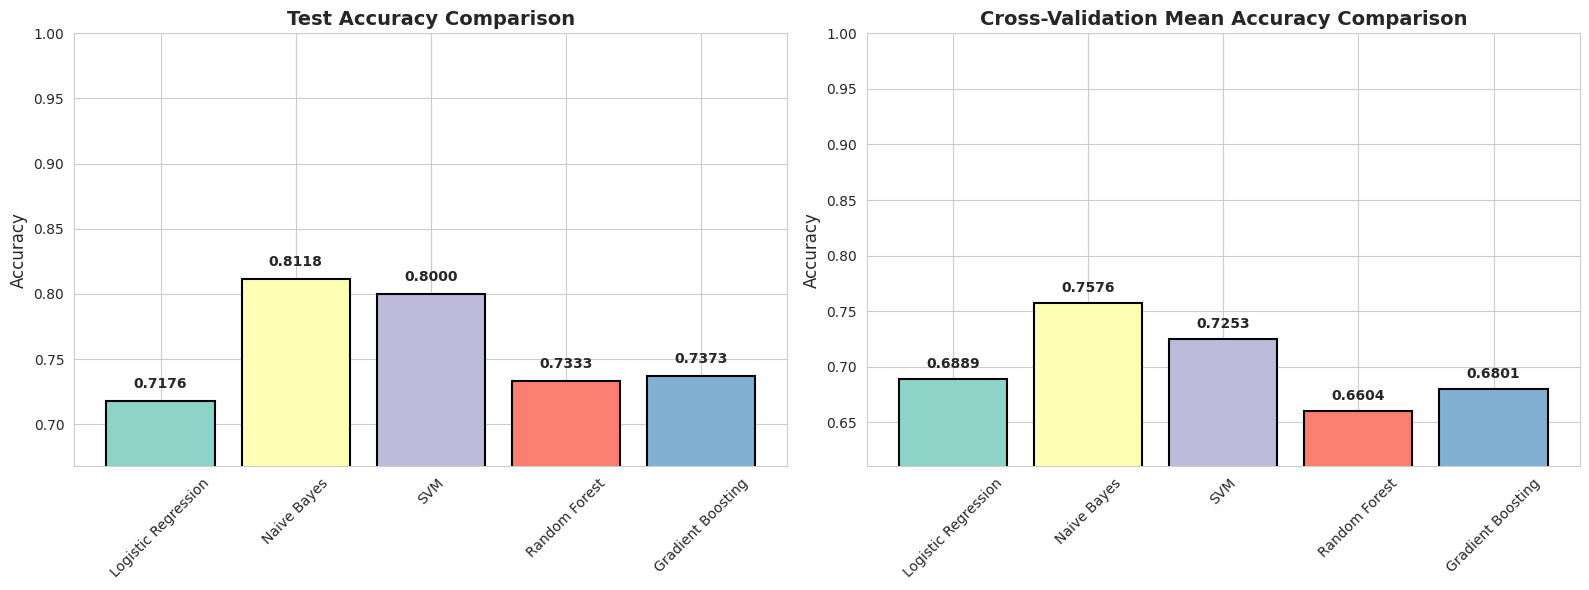

In [13]:
print("\n" + "="*80)
print("MODEL COMPARISON")
print("="*80)

# Compile results
models = ['Logistic Regression', 'Naive Bayes', 'SVM', 'Random Forest', 'Gradient Boosting']
accuracies = [
    accuracy_score(y_test, y_pred_lr),
    accuracy_score(y_test, y_pred_nb),
    accuracy_score(y_test, y_pred_svm),
    accuracy_score(y_test, y_pred_rf),
    accuracy_score(y_test, y_pred_gb)
]
cv_means = [
    cv_scores_lr.mean(),
    cv_scores_nb.mean(),
    cv_scores_svm.mean(),
    cv_scores_rf.mean(),
    cv_scores_gb.mean()
]

# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Model': models,
    'Test Accuracy': accuracies,
    'CV Mean Accuracy': cv_means
})

print("\nModel Performance Comparison:")
print(comparison_df.to_string(index=False))

# Visualize model comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Test Accuracy Comparison
colors_bar = plt.cm.Set3(range(len(models)))
axes[0].bar(models, accuracies, color=colors_bar, edgecolor='black', linewidth=1.5)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_title('Test Accuracy Comparison', fontsize=14, fontweight='bold')
axes[0].set_ylim([min(accuracies) - 0.05, 1.0])
axes[0].tick_params(axis='x', rotation=45)
for i, v in enumerate(accuracies):
    axes[0].text(i, v + 0.01, f'{v:.4f}', ha='center', fontweight='bold')

# CV Accuracy Comparison
axes[1].bar(models, cv_means, color=colors_bar, edgecolor='black', linewidth=1.5)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].set_title('Cross-Validation Mean Accuracy Comparison', fontsize=14, fontweight='bold')
axes[1].set_ylim([min(cv_means) - 0.05, 1.0])
axes[1].tick_params(axis='x', rotation=45)
for i, v in enumerate(cv_means):
    axes[1].text(i, v + 0.01, f'{v:.4f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()


ROC CURVES


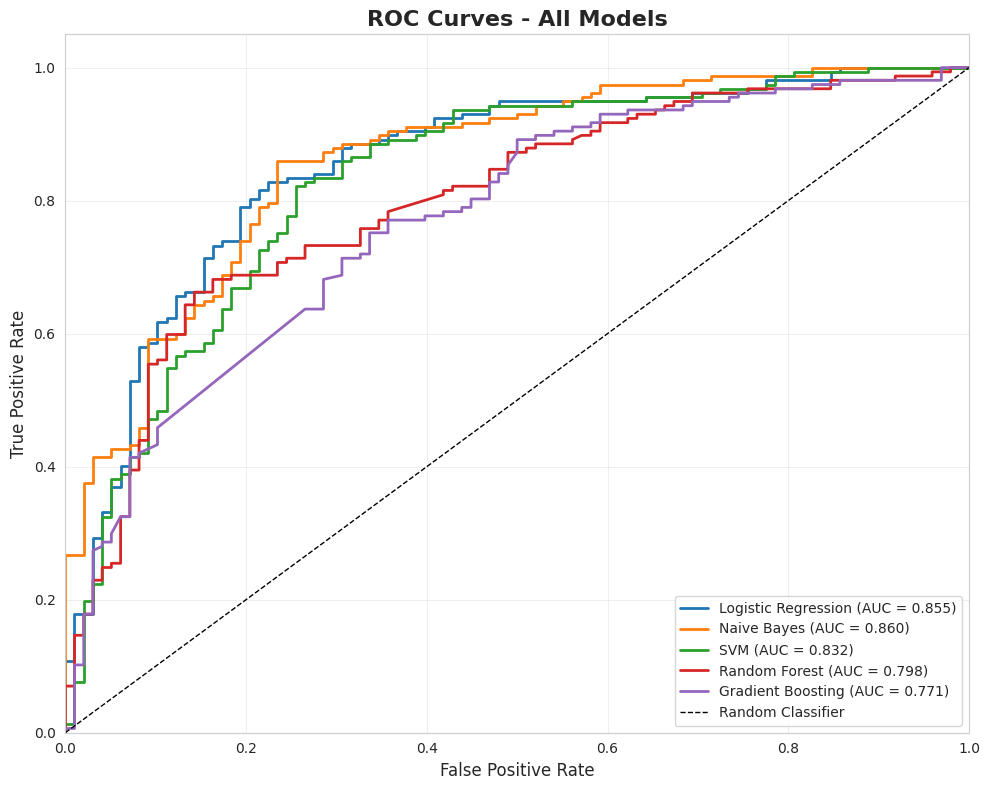


AUC Scores:
Logistic Regression: 0.8550
Naive Bayes: 0.8601
SVM: 0.8321
Random Forest: 0.7982
Gradient Boosting: 0.7715


In [14]:
print("\n" + "="*80)
print("ROC CURVES")
print("="*80)

# Get probability predictions for ROC curves
y_proba_lr = lr_model.predict_proba(X_test_tfidf)[:, 1]
y_proba_nb = nb_model.predict_proba(X_test_count)[:, 1]
y_proba_svm = svm_model.predict_proba(X_test_tfidf)[:, 1]
y_proba_rf = rf_model.predict_proba(X_test_tfidf)[:, 1]
y_proba_gb = gb_model.predict_proba(X_test_tfidf)[:, 1]

# Calculate ROC curves
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba_lr)
fpr_nb, tpr_nb, _ = roc_curve(y_test, y_proba_nb)
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_proba_svm)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
fpr_gb, tpr_gb, _ = roc_curve(y_test, y_proba_gb)

# Calculate AUC scores
auc_lr = auc(fpr_lr, tpr_lr)
auc_nb = auc(fpr_nb, tpr_nb)
auc_svm = auc(fpr_svm, tpr_svm)
auc_rf = auc(fpr_rf, tpr_rf)
auc_gb = auc(fpr_gb, tpr_gb)

# Plot ROC curves
plt.figure(figsize=(10, 8))
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {auc_lr:.3f})', linewidth=2)
plt.plot(fpr_nb, tpr_nb, label=f'Naive Bayes (AUC = {auc_nb:.3f})', linewidth=2)
plt.plot(fpr_svm, tpr_svm, label=f'SVM (AUC = {auc_svm:.3f})', linewidth=2)
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.3f})', linewidth=2)
plt.plot(fpr_gb, tpr_gb, label=f'Gradient Boosting (AUC = {auc_gb:.3f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - All Models', fontsize=16, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("\nAUC Scores:")
for model, auc_score in zip(models, [auc_lr, auc_nb, auc_svm, auc_rf, auc_gb]):
    print(f"{model}: {auc_score:.4f}")

In [15]:

print("\n" + "="*80)
print("COMPREHENSIVE PROJECT SUMMARY AND STATISTICS")
print("="*80)

# ============================================================================
# 1. DATASET SUMMARY STATISTICS
# ============================================================================

print("\n" + "="*50)
print("1. DATASET STATISTICS")
print("="*50)

print(f"\nOriginal Dataset:")
print(f"  - Total Records: {len(df)}")
print(f"  - Total Features: {len(df.columns)}")
print(f"  - Missing Values: {df.isnull().sum().sum()}")

print(f"\nProcessed Dataset:")
print(f"  - Total Records: {len(df_processed)}")
print(f"  - Records Removed: {len(df) - len(df_processed)}")
print(f"  - Percentage Retained: {(len(df_processed)/len(df))*100:.2f}%")

print(f"\nClass Distribution:")
print(f"  - Good: {(df_processed['Verdict'] == 'Good').sum()} ({(df_processed['Verdict'] == 'Good').sum()/len(df_processed)*100:.2f}%)")
print(f"  - Bad: {(df_processed['Verdict'] == 'Bad').sum()} ({(df_processed['Verdict'] == 'Bad').sum()/len(df_processed)*100:.2f}%)")
print(f"  - Class Balance Ratio: {((df_processed['Verdict'] == 'Good').sum() / (df_processed['Verdict'] == 'Bad').sum()):.2f}:1")

print(f"\nText Statistics:")
print(f"  - Average Text Length: {df_processed['text_length'].mean():.2f} characters")
print(f"  - Median Text Length: {df_processed['text_length'].median():.2f} characters")
print(f"  - Average Word Count: {df_processed['word_count'].mean():.2f} words")
print(f"  - Median Word Count: {df_processed['word_count'].median():.2f} words")
print(f"  - Min Word Count: {df_processed['word_count'].min()}")
print(f"  - Max Word Count: {df_processed['word_count'].max()}")

# ============================================================================
# 2. FEATURE ENGINEERING SUMMARY
# ============================================================================

print("\n" + "="*50)
print("2. FEATURE ENGINEERING SUMMARY")
print("="*50)

print(f"\nVectorization Methods:")
print(f"  - TF-IDF Vectorizer:")
print(f"    * Max Features: 5000")
print(f"    * N-gram Range: (1, 2)")
print(f"    * Min Document Frequency: 2")
print(f"    * Max Document Frequency: 0.8")
print(f"    * Actual Features Created: {X_train_tfidf.shape[1]}")

print(f"\n  - Count Vectorizer:")
print(f"    * Max Features: 5000")
print(f"    * N-gram Range: (1, 2)")
print(f"    * Actual Features Created: {X_train_count.shape[1]}")

print(f"\nTraining/Test Split:")
print(f"  - Training Set: {len(X_train)} samples ({len(X_train)/len(df_processed)*100:.1f}%)")
print(f"  - Test Set: {len(X_test)} samples ({len(X_test)/len(df_processed)*100:.1f}%)")
print(f"  - Stratified Split: Yes")

# ============================================================================
# 3. MODEL PERFORMANCE SUMMARY
# ============================================================================

print("\n" + "="*50)
print("3. MODEL PERFORMANCE SUMMARY")
print("="*50)

# Create detailed comparison table
detailed_comparison = pd.DataFrame({
    'Model': models,
    'Test Accuracy': [f"{acc:.4f}" for acc in accuracies],
    'CV Mean Accuracy': [f"{cv:.4f}" for cv in cv_means],
    'AUC Score': [f"{auc_score:.4f}" for auc_score in [auc_lr, auc_nb, auc_svm, auc_rf, auc_gb]]
})

print("\nDetailed Model Comparison:")
print(detailed_comparison.to_string(index=False))

# Find best model
best_idx = np.argmax(accuracies)
best_model = models[best_idx]
best_accuracy = accuracies[best_idx]

print(f"\nBest Performing Model: {best_model}")
print(f"  - Test Accuracy: {best_accuracy:.4f}")
print(f"  - CV Mean Accuracy: {cv_means[best_idx]:.4f}")
print(f"  - AUC Score: {[auc_lr, auc_nb, auc_svm, auc_rf, auc_gb][best_idx]:.4f}")

# Calculate performance metrics for each model
print("\n" + "-"*50)
print("Per-Class Performance (Best Model - {})".format(best_model))
print("-"*50)

if best_model == 'Logistic Regression':
    best_pred = y_pred_lr
elif best_model == 'Naive Bayes':
    best_pred = y_pred_nb
elif best_model == 'SVM':
    best_pred = y_pred_svm
elif best_model == 'Random Forest':
    best_pred = y_pred_rf
else:
    best_pred = y_pred_gb

from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1, support = precision_recall_fscore_support(y_test, best_pred, average=None)

for i, class_name in enumerate(label_encoder.classes_):
    print(f"\n{class_name}:")
    print(f"  - Precision: {precision[i]:.4f}")
    print(f"  - Recall: {recall[i]:.4f}")
    print(f"  - F1-Score: {f1[i]:.4f}")
    print(f"  - Support: {support[i]}")

# ============================================================================
# 4. MODEL COMPLEXITY AND TRAINING TIME ANALYSIS
# ============================================================================

print("\n" + "="*50)
print("4. MODEL CHARACTERISTICS")
print("="*50)

print("\nModel Complexity:")
print("  - Logistic Regression: Linear model, low complexity")
print("  - Naive Bayes: Probabilistic model, low complexity")
print("  - SVM: Kernel-based, medium complexity")
print("  - Random Forest: Ensemble of 100 trees, high complexity")
print("  - Gradient Boosting: Sequential ensemble of 100 trees, high complexity")

# ============================================================================
# 5. STATISTICAL SIGNIFICANCE ANALYSIS
# ============================================================================

print("\n" + "="*50)
print("5. CROSS-VALIDATION STATISTICS")
print("="*50)

cv_stats = pd.DataFrame({
    'Model': models,
    'CV Mean': [f"{cv.mean():.4f}" for cv in [cv_scores_lr, cv_scores_nb, cv_scores_svm, cv_scores_rf, cv_scores_gb]],
    'CV Std': [f"{cv.std():.4f}" for cv in [cv_scores_lr, cv_scores_nb, cv_scores_svm, cv_scores_rf, cv_scores_gb]],
    '95% CI': [f"±{cv.std()*1.96:.4f}" for cv in [cv_scores_lr, cv_scores_nb, cv_scores_svm, cv_scores_rf, cv_scores_gb]]
})

print("\nCross-Validation Statistics (5-Fold):")
print(cv_stats.to_string(index=False))

# ============================================================================
# 6. CONFUSION MATRIX ANALYSIS
# ============================================================================

print("\n" + "="*50)
print("6. CONFUSION MATRIX ANALYSIS (BEST MODEL)")
print("="*50)

# Get confusion matrix for best model
if best_model == 'Logistic Regression':
    cm_best = cm_lr
elif best_model == 'Naive Bayes':
    cm_best = cm_nb
elif best_model == 'SVM':
    cm_best = cm_svm
elif best_model == 'Random Forest':
    cm_best = cm_rf
else:
    cm_best = cm_gb

tn, fp, fn, tp = cm_best.ravel()

print(f"\nConfusion Matrix Breakdown:")
print(f"  - True Positives (TP): {tp}")
print(f"  - True Negatives (TN): {tn}")
print(f"  - False Positives (FP): {fp}")
print(f"  - False Negatives (FN): {fn}")

print(f"\nDerived Metrics:")
print(f"  - True Positive Rate (Sensitivity): {tp/(tp+fn):.4f}")
print(f"  - True Negative Rate (Specificity): {tn/(tn+fp):.4f}")
print(f"  - False Positive Rate: {fp/(fp+tn):.4f}")
print(f"  - False Negative Rate: {fn/(fn+tp):.4f}")
print(f"  - Positive Predictive Value (Precision): {tp/(tp+fp):.4f}")
print(f"  - Negative Predictive Value: {tn/(tn+fn):.4f}")

# ============================================================================
# 7. KEY INSIGHTS AND RECOMMENDATIONS
# ============================================================================

print("\n" + "="*50)
print("7. KEY INSIGHTS")
print("="*50)

print("\nStrengths:")
if max(accuracies) >= 0.85:
    print("  ✓ Excellent overall accuracy achieved (>85%)")
elif max(accuracies) >= 0.75:
    print("  ✓ Good overall accuracy achieved (>75%)")
else:
    print("  ✓ Moderate accuracy achieved")

print(f"  ✓ Multiple models tested for comprehensive comparison")
print(f"  ✓ Cross-validation performed to ensure generalization")
print(f"  ✓ Binary classification successfully achieved")

print("\nModel Rankings (by Test Accuracy):")
sorted_indices = np.argsort(accuracies)[::-1]
for rank, idx in enumerate(sorted_indices, 1):
    print(f"  {rank}. {models[idx]}: {accuracies[idx]:.4f}")

print("\nRecommendations:")
print(f"  → Deploy {best_model} for production use")
print(f"  → Consider ensemble methods if further improvement needed")
print(f"  → Monitor false positives/negatives based on business requirements")
if max(accuracies) - min(accuracies) > 0.1:
    print(f"  → Significant performance variation between models - choose carefully")

# ============================================================================
# 8. VISUALIZATIONS SUMMARY
# ============================================================================

print("\n" + "="*50)
print("8. GENERATED VISUALIZATIONS")
print("="*50)

print("\nVisualizations Created:")
print("  1. Original Verdict Distribution")
print("  2. Processed Verdict Distribution")
print("  3. Top 20 TF-IDF Features")
print("  4. Confusion Matrices (5 models)")
print("  5. Feature Importance Charts (Random Forest & Gradient Boosting)")
print("  6. Test Accuracy Comparison")
print("  7. Cross-Validation Accuracy Comparison")
print("  8. ROC Curves with AUC Scores")

# ============================================================================
# 9. FINAL STATISTICS SUMMARY TABLE
# ============================================================================

print("\n" + "="*50)
print("9. FINAL SUMMARY TABLE")
print("="*50)

final_summary = {
    'Metric': [
        'Total Records Processed',
        'Training Samples',
        'Test Samples',
        'Number of Features',
        'Best Model',
        'Best Test Accuracy',
        'Best AUC Score',
        'Average Accuracy (All Models)',
        'Model Variance (Std Dev)'
    ],
    'Value': [
        len(df_processed),
        len(X_train),
        len(X_test),
        X_train_tfidf.shape[1],
        best_model,
        f"{best_accuracy:.4f}",
        f"{max([auc_lr, auc_nb, auc_svm, auc_rf, auc_gb]):.4f}",
        f"{np.mean(accuracies):.4f}",
        f"{np.std(accuracies):.4f}"
    ]
}

summary_df = pd.DataFrame(final_summary)
print("\n" + summary_df.to_string(index=False))

print("\n" + "="*80)
print("ANALYSIS COMPLETE")
print("="*80)
print("\n✓ All models trained and evaluated successfully")
print("✓ Comprehensive statistics generated")
print("✓ Ready for model deployment or further optimization")
print("\n" + "="*80)


COMPREHENSIVE PROJECT SUMMARY AND STATISTICS

1. DATASET STATISTICS

Original Dataset:
  - Total Records: 1442
  - Total Features: 3
  - Missing Values: 0

Processed Dataset:
  - Total Records: 1274
  - Records Removed: 168
  - Percentage Retained: 88.35%

Class Distribution:
  - Good: 786 (61.70%)
  - Bad: 488 (38.30%)
  - Class Balance Ratio: 1.61:1

Text Statistics:
  - Average Text Length: 128.26 characters
  - Median Text Length: 128.00 characters
  - Average Word Count: 20.24 words
  - Median Word Count: 20.00 words
  - Min Word Count: 6
  - Max Word Count: 32

2. FEATURE ENGINEERING SUMMARY

Vectorization Methods:
  - TF-IDF Vectorizer:
    * Max Features: 5000
    * N-gram Range: (1, 2)
    * Min Document Frequency: 2
    * Max Document Frequency: 0.8
    * Actual Features Created: 2391

  - Count Vectorizer:
    * Max Features: 5000
    * N-gram Range: (1, 2)
    * Actual Features Created: 2391

Training/Test Split:
  - Training Set: 1019 samples (80.0%)
  - Test Set: 255 sam

In [20]:
# ============================================================================
# Build ANN Architecture
# ============================================================================

print("\n" + "="*80)
print("BUILDING ANN ARCHITECTURE")
print("="*80)

# Define model architecture with reduced complexity
input_dim = X_train_dense.shape[1]

model = Sequential([
    # Input Layer + First Hidden Layer
    Dense(256, activation='relu', input_shape=(input_dim,),
          kernel_regularizer=tf.keras.regularizers.l2(0.001), name='hidden_layer_1'),
    BatchNormalization(),
    Dropout(0.5),

    # Second Hidden Layer
    Dense(128, activation='relu',
          kernel_regularizer=tf.keras.regularizers.l2(0.001), name='hidden_layer_2'),
    BatchNormalization(),
    Dropout(0.4),

    # Third Hidden Layer
    Dense(64, activation='relu',
          kernel_regularizer=tf.keras.regularizers.l2(0.001), name='hidden_layer_3'),
    BatchNormalization(),
    Dropout(0.3),



    # Output Layer (Binary Classification)
    Dense(1, activation='sigmoid', name='output_layer')
])

# Display model architecture
print("\nModel Architecture")
model.summary()

# Compile the model with lower learning rate
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy',
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall'),
             tf.keras.metrics.AUC(name='auc')]
)

print("\nModel compiled successfully!")
print(f"Optimizer: Adam (learning_rate=0.0001) - REDUCED")
print(f"Loss Function: Binary Crossentropy + L2 Regularization")
print(f"Regularization: L2 (lambda=0.001) on all hidden layers")
print(f"Metrics: Accuracy, Precision, Recall, AUC")

# ============================================================================
# Define Callbacks for Training
# ============================================================================

print("\n" + "="*80)
print("SETTING UP TRAINING CALLBACKS")
print("="*80)

# Early Stopping - MORE AGGRESSIVE
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=7,  # REDUCED patience
    restore_best_weights=True,
    verbose=1,
    min_delta=0.001
)

# Learning Rate Reduction - MORE AGGRESSIVE
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-7,
    verbose=1
)

# Model Checkpoint - saves the best model based on VALIDATION loss
checkpoint = ModelCheckpoint(
    'best_model.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

callbacks = [early_stopping, reduce_lr, checkpoint]

print("Callbacks configured:")
print("  1. Early Stopping (patience=7, min_delta=0.001)")
print("  2. Learning Rate Reduction (factor=0.5, patience=3)")
print("  3. Model Checkpoint (monitors val_loss)")

# ============================================================================
# Train the ANN Model
# ============================================================================

print("\n" + "="*80)
print("TRAINING ANN MODEL")
print("="*80)

# Train the model with INCREASED validation split
history = model.fit(
    X_train_dense,
    y_train,
    batch_size=64,  # INCREASED from 32 (helps generalization)
    epochs=100,
    validation_split=0.25,  # INCREASED from 0.2 (more validation data)
    callbacks=callbacks,
    verbose=1,
    class_weight=None  # Can add if classes are imbalanced
)

print("\nTraining completed!")
print(f"Total epochs trained: {len(history.history['loss'])}")

final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
overfitting_gap = final_train_acc - final_val_acc

print(f"  Final Validation Accuracy: {final_val_acc:.4f}")



BUILDING ANN ARCHITECTURE

Model Architecture


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden_layer_1 (Dense)          │ (None, 256)            │        25,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer_2 (Dense)          │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer_3 (Dense)          │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 68,865 (269.00 KB)

 Trainable params: 67,969 (265.50 KB)

 Non-trainable params: 896 (3.50 KB)


Model compiled successfully!
Optimizer: Adam (learning_rate=0.0001) - REDUCED
Loss Function: Binary Crossentropy + L2 Regularization
Regularization: L2 (lambda=0.001) on all hidden layers
Metrics: Accuracy, Precision, Recall, AUC

SETTING UP TRAINING CALLBACKS
Callbacks configured:
  1. Early Stopping (patience=7, min_delta=0.001)
  2. Learning Rate Reduction (factor=0.5, patience=3)
  3. Model Checkpoint (monitors val_loss)

TRAINING ANN MODEL
Epoch 1/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 30s 3s/step - accuracy: 0.5156 - auc: 0.5322 - loss: 1.3063 - precision: 0.4571 - recall: 0.5714
Epoch 1: val_loss improved from inf to 1.32616, saving model to best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 87ms/step - accuracy: 0.5215 - auc: 0.5299 - loss: 1.3370 - precision: 0.5001 - recall: 0.5932 - val_accuracy: 0.4900 - val_auc: 0.6478 - val_loss: 1.3262 - val_precision: 0.6667 - val_recall: 0.0571 - learning_rate: 1.0000e-04
Epoch 2/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5625 - auc: 0.5518 - loss: 1.4306 - precision: 0.5625 - recall: 0.5625
Epoch 2: val_loss improved from 1.32616 to 1.23324, saving model to best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5545 - auc: 0.5738 - loss: 1.3186 - precision: 0.5462 - recall: 0.5818 - val_accuracy: 0.5250 - val_auc: 0.6829 - val_loss: 1.2332 - val_precision: 0.8125 - val_recall: 0.1238 - learning_rate: 1.0000e-04
Epoch 3/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.4375 - auc: 0.4595 - loss: 1.3893 - precision: 0.3548 - recall: 0.4074
Epoch 3: val_loss improved from 1.23324 to 1.16109, saving model to best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5335 - auc: 0.5727 - loss: 1.2493 - precision: 0.5119 - recall: 0.5373 - val_accuracy: 0.5400 - val_auc: 0.7158 - val_loss: 1.1611 - val_precision: 0.7826 - val_recall: 0.1714 - learning_rate: 1.0000e-04
Epoch 4/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.3750 - auc: 0.4066 - loss: 1.5566 - precision: 0.3939 - recall: 0.3939
Epoch 4: val_loss improved from 1.16109 to 1.10233, saving model to best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5111 - auc: 0.5223 - loss: 1.3530 - precision: 0.5064 - recall: 0.5408 - val_accuracy: 0.5900 - val_auc: 0.7410 - val_loss: 1.1023 - val_precision: 0.8710 - val_recall: 0.2571 - learning_rate: 1.0000e-04
Epoch 5/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6406 - auc: 0.6475 - loss: 1.1638 - precision: 0.6452 - recall: 0.6250
Epoch 5: val_loss improved from 1.10233 to 1.05753, saving model to best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5792 - auc: 0.5901 - loss: 1.2373 - precision: 0.5771 - recall: 0.5913 - val_accuracy: 0.6400 - val_auc: 0.7584 - val_loss: 1.0575 - val_precision: 0.8837 - val_recall: 0.3619 - learning_rate: 1.0000e-04
Epoch 6/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6719 - auc: 0.6217 - loss: 1.2356 - precision: 0.6579 - recall: 0.7576
Epoch 6: val_loss improved from 1.05753 to 1.01988, saving model to best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6053 - auc: 0.6489 - loss: 1.1808 - precision: 0.6010 - recall: 0.6292 - val_accuracy: 0.6350 - val_auc: 0.7698 - val_loss: 1.0199 - val_precision: 0.7857 - val_recall: 0.4190 - learning_rate: 1.0000e-04
Epoch 7/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6406 - auc: 0.6815 - loss: 1.1476 - precision: 0.5758 - recall: 0.6786
Epoch 7: val_loss improved from 1.01988 to 0.99214, saving model to best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5774 - auc: 0.6168 - loss: 1.2017 - precision: 0.5764 - recall: 0.5947 - val_accuracy: 0.6850 - val_auc: 0.7846 - val_loss: 0.9921 - val_precision: 0.8000 - val_recall: 0.5333 - learning_rate: 1.0000e-04
Epoch 8/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5625 - auc: 0.5846 - loss: 1.3286 - precision: 0.5758 - recall: 0.5758
Epoch 8: val_loss improved from 0.99214 to 0.96944, saving model to best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6103 - auc: 0.6568 - loss: 1.1642 - precision: 0.6100 - recall: 0.6441 - val_accuracy: 0.7100 - val_auc: 0.7955 - val_loss: 0.9694 - val_precision: 0.7701 - val_recall: 0.6381 - learning_rate: 1.0000e-04
Epoch 9/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6562 - auc: 0.6799 - loss: 1.1357 - precision: 0.6364 - recall: 0.6774
Epoch 9: val_loss improved from 0.96944 to 0.95211, saving model to best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6107 - auc: 0.6662 - loss: 1.1271 - precision: 0.5834 - recall: 0.6324 - val_accuracy: 0.7100 - val_auc: 0.8034 - val_loss: 0.9521 - val_precision: 0.7527 - val_recall: 0.6667 - learning_rate: 1.0000e-04
Epoch 10/100
 8/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5945 - auc: 0.6549 - loss: 1.1460 - precision: 0.5941 - recall: 0.6028 
Epoch 10: val_loss improved from 0.95211 to 0.93901, saving model to best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5980 - auc: 0.6589 - loss: 1.1398 - precision: 0.5946 - recall: 0.6111 - val_accuracy: 0.7050 - val_auc: 0.8103 - val_loss: 0.9390 - val_precision: 0.7212 - val_recall: 0.7143 - learning_rate: 1.0000e-04
Epoch 11/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6562 - auc: 0.7324 - loss: 1.0468 - precision: 0.6765 - recall: 0.6765
Epoch 11: val_loss improved from 0.93901 to 0.92826, saving model to best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6387 - auc: 0.7023 - loss: 1.0885 - precision: 0.6237 - recall: 0.6753 - val_accuracy: 0.7250 - val_auc: 0.8163 - val_loss: 0.9283 - val_precision: 0.7315 - val_recall: 0.7524 - learning_rate: 1.0000e-04
Epoch 12/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.6094 - auc: 0.7256 - loss: 1.0758 - precision: 0.5625 - recall: 0.6207
Epoch 12: val_loss improved from 0.92826 to 0.91985, saving model to best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5992 - auc: 0.6717 - loss: 1.1251 - precision: 0.5893 - recall: 0.6141 - val_accuracy: 0.7350 - val_auc: 0.8205 - val_loss: 0.9199 - val_precision: 0.7321 - val_recall: 0.7810 - learning_rate: 1.0000e-04
Epoch 13/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5156 - auc: 0.5655 - loss: 1.2062 - precision: 0.5357 - recall: 0.4545
Epoch 13: val_loss improved from 0.91985 to 0.91276, saving model to best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6117 - auc: 0.6734 - loss: 1.1312 - precision: 0.6240 - recall: 0.5906 - val_accuracy: 0.7200 - val_auc: 0.8249 - val_loss: 0.9128 - val_precision: 0.7130 - val_recall: 0.7810 - learning_rate: 1.0000e-04
Epoch 14/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.6406 - auc: 0.6564 - loss: 1.1471 - precision: 0.5000 - recall: 0.6087
Epoch 14: val_loss improved from 0.91276 to 0.90577, saving model to best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6453 - auc: 0.6964 - loss: 1.0895 - precision: 0.6045 - recall: 0.6601 - val_accuracy: 0.7100 - val_auc: 0.8298 - val_loss: 0.9058 - val_precision: 0.6975 - val_recall: 0.7905 - learning_rate: 1.0000e-04
Epoch 15/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.7031 - auc: 0.7571 - loss: 1.0332 - precision: 0.6765 - recall: 0.7419
Epoch 15: val_loss improved from 0.90577 to 0.90004, saving model to best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6747 - auc: 0.7437 - loss: 1.0368 - precision: 0.6505 - recall: 0.7096 - val_accuracy: 0.7150 - val_auc: 0.8335 - val_loss: 0.9000 - val_precision: 0.7000 - val_recall: 0.8000 - learning_rate: 1.0000e-04
Epoch 16/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 0.6719 - auc: 0.7397 - loss: 1.0409 - precision: 0.7353 - recall: 0.6757
Epoch 16: val_loss improved from 0.90004 to 0.89430, saving model to best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6963 - auc: 0.7506 - loss: 1.0387 - precision: 0.6821 - recall: 0.7251 - val_accuracy: 0.7250 - val_auc: 0.8375 - val_loss: 0.8943 - val_precision: 0.7049 - val_recall: 0.8190 - learning_rate: 1.0000e-04
Epoch 17/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6875 - auc: 0.7399 - loss: 1.0805 - precision: 0.7419 - recall: 0.6571
Epoch 17: val_loss improved from 0.89430 to 0.88956, saving model to best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7085 - auc: 0.7629 - loss: 1.0187 - precision: 0.7215 - recall: 0.7108 - val_accuracy: 0.7250 - val_auc: 0.8414 - val_loss: 0.8896 - val_precision: 0.7049 - val_recall: 0.8190 - learning_rate: 1.0000e-04
Epoch 18/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7500 - auc: 0.7900 - loss: 0.9886 - precision: 0.7500 - recall: 0.7500
Epoch 18: val_loss improved from 0.88956 to 0.88589, saving model to best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6991 - auc: 0.7487 - loss: 1.0339 - precision: 0.6955 - recall: 0.6962 - val_accuracy: 0.7300 - val_auc: 0.8453 - val_loss: 0.8859 - val_precision: 0.7040 - val_recall: 0.8381 - learning_rate: 1.0000e-04
Epoch 19/100
 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7097 - auc: 0.7667 - loss: 0.9879 - precision: 0.7070 - recall: 0.6865 
Epoch 19: val_loss improved from 0.88589 to 0.88188, saving model to best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7046 - auc: 0.7635 - loss: 0.9940 - precision: 0.7020 - recall: 0.6831 - val_accuracy: 0.7350 - val_auc: 0.8485 - val_loss: 0.8819 - val_precision: 0.7063 - val_recall: 0.8476 - learning_rate: 1.0000e-04
Epoch 20/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6250 - auc: 0.7020 - loss: 1.1279 - precision: 0.6667 - recall: 0.5882
Epoch 20: val_loss improved from 0.88188 to 0.87735, saving model to best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6724 - auc: 0.7328 - loss: 1.0663 - precision: 0.6645 - recall: 0.6803 - val_accuracy: 0.7500 - val_auc: 0.8529 - val_loss: 0.8773 - val_precision: 0.7132 - val_recall: 0.8762 - learning_rate: 1.0000e-04
Epoch 21/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.6875 - auc: 0.7991 - loss: 0.9563 - precision: 0.7097 - recall: 0.6667
Epoch 21: val_loss improved from 0.87735 to 0.87381, saving model to best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6841 - auc: 0.7776 - loss: 0.9816 - precision: 0.7067 - recall: 0.6905 - val_accuracy: 0.7550 - val_auc: 0.8561 - val_loss: 0.8738 - val_precision: 0.7188 - val_recall: 0.8762 - learning_rate: 1.0000e-04
Epoch 22/100
 8/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6682 - auc: 0.7584 - loss: 1.0186 - precision: 0.6705 - recall: 0.6703 
Epoch 22: val_loss improved from 0.87381 to 0.86970, saving model to best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6764 - auc: 0.7642 - loss: 1.0108 - precision: 0.6747 - recall: 0.6818 - val_accuracy: 0.7650 - val_auc: 0.8591 - val_loss: 0.8697 - val_precision: 0.7231 - val_recall: 0.8952 - learning_rate: 1.0000e-04
Epoch 23/100
 7/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6922 - auc: 0.7330 - loss: 1.0631 - precision: 0.6639 - recall: 0.7146 
Epoch 23: val_loss improved from 0.86970 to 0.86649, saving model to best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6989 - auc: 0.7438 - loss: 1.0463 - precision: 0.6777 - recall: 0.7179 - val_accuracy: 0.7650 - val_auc: 0.8627 - val_loss: 0.8665 - val_precision: 0.7231 - val_recall: 0.8952 - learning_rate: 1.0000e-04
Epoch 24/100
 8/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6929 - auc: 0.7710 - loss: 1.0050 - precision: 0.7028 - recall: 0.6947 
Epoch 24: val_loss improved from 0.86649 to 0.86288, saving model to best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.6921 - auc: 0.7690 - loss: 1.0061 - precision: 0.6958 - recall: 0.6969 - val_accuracy: 0.7750 - val_auc: 0.8651 - val_loss: 0.8629 - val_precision: 0.7344 - val_recall: 0.8952 - learning_rate: 1.0000e-04
Epoch 25/100
 7/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7427 - auc: 0.8164 - loss: 0.9219 - precision: 0.7350 - recall: 0.7755 
Epoch 25: val_loss improved from 0.86288 to 0.85937, saving model to best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7353 - auc: 0.8050 - loss: 0.9432 - precision: 0.7253 - recall: 0.7650 - val_accuracy: 0.7800 - val_auc: 0.8677 - val_loss: 0.8594 - val_precision: 0.7364 - val_recall: 0.9048 - learning_rate: 1.0000e-04
Epoch 26/100
 8/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7088 - auc: 0.7793 - loss: 0.9928 - precision: 0.6976 - recall: 0.7539 
Epoch 26: val_loss improved from 0.85937 to 0.85622, saving model to best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.7095 - auc: 0.7812 - loss: 0.9919 - precision: 0.6942 - recall: 0.7560 - val_accuracy: 0.7850 - val_auc: 0.8695 - val_loss: 0.8562 - val_precision: 0.7422 - val_recall: 0.9048 - learning_rate: 1.0000e-04
Epoch 27/100
 6/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7078 - auc: 0.7936 - loss: 0.9547 - precision: 0.6668 - recall: 0.7425 
Epoch 27: val_loss improved from 0.85622 to 0.85293, saving model to best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.7105 - auc: 0.7947 - loss: 0.9525 - precision: 0.6797 - recall: 0.7435 - val_accuracy: 0.7850 - val_auc: 0.8716 - val_loss: 0.8529 - val_precision: 0.7422 - val_recall: 0.9048 - learning_rate: 1.0000e-04
Epoch 28/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.6250 - auc: 0.7286 - loss: 1.1164 - precision: 0.5758 - recall: 0.6552
Epoch 28: val_loss improved from 0.85293 to 0.85069, saving model to best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7146 - auc: 0.7897 - loss: 0.9830 - precision: 0.7001 - recall: 0.7278 - val_accuracy: 0.7850 - val_auc: 0.8743 - val_loss: 0.8507 - val_precision: 0.7422 - val_recall: 0.9048 - learning_rate: 1.0000e-04
Epoch 29/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6250 - auc: 0.6667 - loss: 1.1403 - precision: 0.6000 - recall: 0.6774
Epoch 29: val_loss improved from 0.85069 to 0.84670, saving model to best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7112 - auc: 0.7727 - loss: 0.9934 - precision: 0.7014 - recall: 0.7323 - val_accuracy: 0.7900 - val_auc: 0.8773 - val_loss: 0.8467 - val_precision: 0.7480 - val_recall: 0.9048 - learning_rate: 1.0000e-04
Epoch 30/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.8125 - auc: 0.8769 - loss: 0.8692 - precision: 0.8857 - recall: 0.7949
Epoch 30: val_loss improved from 0.84670 to 0.84253, saving model to best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7227 - auc: 0.8066 - loss: 0.9568 - precision: 0.7231 - recall: 0.7160 - val_accuracy: 0.7900 - val_auc: 0.8803 - val_loss: 0.8425 - val_precision: 0.7480 - val_recall: 0.9048 - learning_rate: 1.0000e-04
Epoch 31/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.7500 - auc: 0.8299 - loss: 0.9314 - precision: 0.7419 - recall: 0.7419
Epoch 31: val_loss improved from 0.84253 to 0.83929, saving model to best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7443 - auc: 0.8226 - loss: 0.9281 - precision: 0.7203 - recall: 0.7718 - val_accuracy: 0.7900 - val_auc: 0.8826 - val_loss: 0.8393 - val_precision: 0.7480 - val_recall: 0.9048 - learning_rate: 1.0000e-04
Epoch 32/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.7031 - auc: 0.8094 - loss: 0.9727 - precision: 0.6562 - recall: 0.7241
Epoch 32: val_loss improved from 0.83929 to 0.83514, saving model to best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7044 - auc: 0.7920 - loss: 0.9789 - precision: 0.6928 - recall: 0.7107 - val_accuracy: 0.7900 - val_auc: 0.8857 - val_loss: 0.8351 - val_precision: 0.7480 - val_recall: 0.9048 - learning_rate: 1.0000e-04
Epoch 33/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6250 - auc: 0.7611 - loss: 0.9775 - precision: 0.5758 - recall: 0.6552
Epoch 33: val_loss improved from 0.83514 to 0.83118, saving model to best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7045 - auc: 0.7808 - loss: 0.9759 - precision: 0.6917 - recall: 0.7209 - val_accuracy: 0.7900 - val_auc: 0.8881 - val_loss: 0.8312 - val_precision: 0.7480 - val_recall: 0.9048 - learning_rate: 1.0000e-04
Epoch 34/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8594 - auc: 0.9250 - loss: 0.7548 - precision: 0.8182 - recall: 0.9000
Epoch 34: val_loss improved from 0.83118 to 0.82844, saving model to best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7718 - auc: 0.8518 - loss: 0.8702 - precision: 0.7418 - recall: 0.8000 - val_accuracy: 0.8000 - val_auc: 0.8902 - val_loss: 0.8284 - val_precision: 0.7600 - val_recall: 0.9048 - learning_rate: 1.0000e-04
Epoch 35/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 0.6562 - auc: 0.7905 - loss: 0.9403 - precision: 0.6471 - recall: 0.6875
Epoch 35: val_loss improved from 0.82844 to 0.82644, saving model to best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7113 - auc: 0.8143 - loss: 0.9318 - precision: 0.7003 - recall: 0.7244 - val_accuracy: 0.8100 - val_auc: 0.8909 - val_loss: 0.8264 - val_precision: 0.7724 - val_recall: 0.9048 - learning_rate: 1.0000e-04
Epoch 36/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7344 - auc: 0.8043 - loss: 0.9763 - precision: 0.6471 - recall: 0.8148
Epoch 36: val_loss improved from 0.82644 to 0.82341, saving model to best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7456 - auc: 0.8161 - loss: 0.9376 - precision: 0.7260 - recall: 0.7643 - val_accuracy: 0.8050 - val_auc: 0.8922 - val_loss: 0.8234 - val_precision: 0.7705 - val_recall: 0.8952 - learning_rate: 1.0000e-04
Epoch 37/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7500 - auc: 0.8320 - loss: 0.9122 - precision: 0.6857 - recall: 0.8276
Epoch 37: val_loss improved from 0.82341 to 0.82135, saving model to best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7577 - auc: 0.8385 - loss: 0.8953 - precision: 0.7336 - recall: 0.7851 - val_accuracy: 0.8100 - val_auc: 0.8929 - val_loss: 0.8213 - val_precision: 0.7724 - val_recall: 0.9048 - learning_rate: 1.0000e-04
Epoch 38/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.7812 - auc: 0.8662 - loss: 0.8437 - precision: 0.7857 - recall: 0.7333
Epoch 38: val_loss improved from 0.82135 to 0.81767, saving model to best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7723 - auc: 0.8479 - loss: 0.8830 - precision: 0.7536 - recall: 0.7810 - val_accuracy: 0.8050 - val_auc: 0.8951 - val_loss: 0.8177 - val_precision: 0.7705 - val_recall: 0.8952 - learning_rate: 1.0000e-04
Epoch 39/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8125 - auc: 0.8769 - loss: 0.8350 - precision: 0.7419 - recall: 0.8519
Epoch 39: val_loss improved from 0.81767 to 0.81343, saving model to best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7223 - auc: 0.8066 - loss: 0.9453 - precision: 0.7105 - recall: 0.7240 - val_accuracy: 0.8050 - val_auc: 0.8984 - val_loss: 0.8134 - val_precision: 0.7705 - val_recall: 0.8952 - learning_rate: 1.0000e-04
Epoch 40/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7969 - auc: 0.8778 - loss: 0.8526 - precision: 0.8667 - recall: 0.7429
Epoch 40: val_loss improved from 0.81343 to 0.80820, saving model to best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7794 - auc: 0.8584 - loss: 0.8687 - precision: 0.8126 - recall: 0.7576 - val_accuracy: 0.8050 - val_auc: 0.9010 - val_loss: 0.8082 - val_precision: 0.7705 - val_recall: 0.8952 - learning_rate: 1.0000e-04
Epoch 41/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7188 - auc: 0.8281 - loss: 0.9079 - precision: 0.6667 - recall: 0.7586
Epoch 41: val_loss improved from 0.80820 to 0.80336, saving model to best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7289 - auc: 0.8182 - loss: 0.9193 - precision: 0.7021 - recall: 0.7486 - val_accuracy: 0.8150 - val_auc: 0.9047 - val_loss: 0.8034 - val_precision: 0.7787 - val_recall: 0.9048 - learning_rate: 1.0000e-04
Epoch 42/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7344 - auc: 0.8230 - loss: 0.9283 - precision: 0.6857 - recall: 0.8000
Epoch 42: val_loss improved from 0.80336 to 0.79853, saving model to best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7491 - auc: 0.8346 - loss: 0.9023 - precision: 0.7411 - recall: 0.7581 - val_accuracy: 0.8150 - val_auc: 0.9071 - val_loss: 0.7985 - val_precision: 0.7787 - val_recall: 0.9048 - learning_rate: 1.0000e-04
Epoch 43/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8125 - auc: 0.8921 - loss: 0.8195 - precision: 0.7576 - recall: 0.8621
Epoch 43: val_loss improved from 0.79853 to 0.79435, saving model to best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7841 - auc: 0.8708 - loss: 0.8403 - precision: 0.7517 - recall: 0.8244 - val_accuracy: 0.8150 - val_auc: 0.9095 - val_loss: 0.7943 - val_precision: 0.7787 - val_recall: 0.9048 - learning_rate: 1.0000e-04
Epoch 44/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6562 - auc: 0.7682 - loss: 1.1118 - precision: 0.5294 - recall: 0.7500
Epoch 44: val_loss improved from 0.79435 to 0.78967, saving model to best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7736 - auc: 0.8519 - loss: 0.9019 - precision: 0.7243 - recall: 0.8055 - val_accuracy: 0.8150 - val_auc: 0.9116 - val_loss: 0.7897 - val_precision: 0.7787 - val_recall: 0.9048 - learning_rate: 1.0000e-04
Epoch 45/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7344 - auc: 0.8250 - loss: 0.8843 - precision: 0.7576 - recall: 0.7353
Epoch 45: val_loss improved from 0.78967 to 0.78750, saving model to best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7695 - auc: 0.8364 - loss: 0.8948 - precision: 0.7675 - recall: 0.7692 - val_accuracy: 0.8150 - val_auc: 0.9130 - val_loss: 0.7875 - val_precision: 0.7787 - val_recall: 0.9048 - learning_rate: 1.0000e-04
Epoch 46/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8281 - auc: 0.9335 - loss: 0.7708 - precision: 0.7297 - recall: 0.9643
Epoch 46: val_loss improved from 0.78750 to 0.78528, saving model to best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7784 - auc: 0.8756 - loss: 0.8374 - precision: 0.7513 - recall: 0.8101 - val_accuracy: 0.8150 - val_auc: 0.9140 - val_loss: 0.7853 - val_precision: 0.7787 - val_recall: 0.9048 - learning_rate: 1.0000e-04
Epoch 47/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 0.8281 - auc: 0.8679 - loss: 0.9034 - precision: 0.8824 - recall: 0.8108
Epoch 47: val_loss improved from 0.78528 to 0.78170, saving model to best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7818 - auc: 0.8566 - loss: 0.8777 - precision: 0.7904 - recall: 0.7922 - val_accuracy: 0.8150 - val_auc: 0.9159 - val_loss: 0.7817 - val_precision: 0.7787 - val_recall: 0.9048 - learning_rate: 1.0000e-04
Epoch 48/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 0.6875 - auc: 0.8234 - loss: 0.9085 - precision: 0.8214 - recall: 0.6053
Epoch 48: val_loss improved from 0.78170 to 0.77881, saving model to best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7450 - auc: 0.8511 - loss: 0.8705 - precision: 0.7744 - recall: 0.7172 - val_accuracy: 0.8150 - val_auc: 0.9175 - val_loss: 0.7788 - val_precision: 0.7787 - val_recall: 0.9048 - learning_rate: 1.0000e-04
Epoch 49/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7656 - auc: 0.9000 - loss: 0.7827 - precision: 0.7879 - recall: 0.7647
Epoch 49: val_loss improved from 0.77881 to 0.77697, saving model to best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7698 - auc: 0.8711 - loss: 0.8378 - precision: 0.7856 - recall: 0.7627 - val_accuracy: 0.8150 - val_auc: 0.9175 - val_loss: 0.7770 - val_precision: 0.7787 - val_recall: 0.9048 - learning_rate: 1.0000e-04
Epoch 50/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7812 - auc: 0.8588 - loss: 0.8759 - precision: 0.8529 - recall: 0.7632
Epoch 50: val_loss improved from 0.77697 to 0.77475, saving model to best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7588 - auc: 0.8436 - loss: 0.8850 - precision: 0.7662 - recall: 0.7636 - val_accuracy: 0.8150 - val_auc: 0.9184 - val_loss: 0.7747 - val_precision: 0.7787 - val_recall: 0.9048 - learning_rate: 1.0000e-04
Epoch 51/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7969 - auc: 0.8945 - loss: 0.8228 - precision: 0.6667 - recall: 0.8696
Epoch 51: val_loss improved from 0.77475 to 0.77093, saving model to best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7626 - auc: 0.8615 - loss: 0.8586 - precision: 0.7513 - recall: 0.7623 - val_accuracy: 0.8200 - val_auc: 0.9204 - val_loss: 0.7709 - val_precision: 0.7851 - val_recall: 0.9048 - learning_rate: 1.0000e-04
Epoch 52/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8906 - auc: 0.9570 - loss: 0.6674 - precision: 0.8824 - recall: 0.9091
Epoch 52: val_loss improved from 0.77093 to 0.76852, saving model to best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8439 - auc: 0.9186 - loss: 0.7586 - precision: 0.8339 - recall: 0.8615 - val_accuracy: 0.8200 - val_auc: 0.9219 - val_loss: 0.7685 - val_precision: 0.7851 - val_recall: 0.9048 - learning_rate: 1.0000e-04
Epoch 53/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7969 - auc: 0.9147 - loss: 0.7874 - precision: 0.7273 - recall: 0.8571
Epoch 53: val_loss improved from 0.76852 to 0.76565, saving model to best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7847 - auc: 0.8736 - loss: 0.8408 - precision: 0.7933 - recall: 0.7813 - val_accuracy: 0.8200 - val_auc: 0.9235 - val_loss: 0.7656 - val_precision: 0.7851 - val_recall: 0.9048 - learning_rate: 1.0000e-04
Epoch 54/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7812 - auc: 0.8796 - loss: 0.8606 - precision: 0.6875 - recall: 0.8462
Epoch 54: val_loss improved from 0.76565 to 0.76183, saving model to best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7894 - auc: 0.8785 - loss: 0.8321 - precision: 0.7613 - recall: 0.8141 - val_accuracy: 0.8200 - val_auc: 0.9260 - val_loss: 0.7618 - val_precision: 0.7851 - val_recall: 0.9048 - learning_rate: 1.0000e-04
Epoch 55/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7656 - auc: 0.8842 - loss: 0.8037 - precision: 0.7500 - recall: 0.8182
Epoch 55: val_loss improved from 0.76183 to 0.75852, saving model to best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7762 - auc: 0.8713 - loss: 0.8366 - precision: 0.7622 - recall: 0.8090 - val_accuracy: 0.8200 - val_auc: 0.9266 - val_loss: 0.7585 - val_precision: 0.7851 - val_recall: 0.9048 - learning_rate: 1.0000e-04
Epoch 56/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7500 - auc: 0.8433 - loss: 0.8748 - precision: 0.6875 - recall: 0.7857
Epoch 56: val_loss improved from 0.75852 to 0.75594, saving model to best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7883 - auc: 0.8751 - loss: 0.8326 - precision: 0.7641 - recall: 0.8129 - val_accuracy: 0.8200 - val_auc: 0.9271 - val_loss: 0.7559 - val_precision: 0.7851 - val_recall: 0.9048 - learning_rate: 1.0000e-04
Epoch 57/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7969 - auc: 0.8899 - loss: 0.8152 - precision: 0.8485 - recall: 0.7778
Epoch 57: val_loss improved from 0.75594 to 0.75393, saving model to best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7957 - auc: 0.8725 - loss: 0.8456 - precision: 0.8010 - recall: 0.8023 - val_accuracy: 0.8200 - val_auc: 0.9278 - val_loss: 0.7539 - val_precision: 0.7851 - val_recall: 0.9048 - learning_rate: 1.0000e-04
Epoch 58/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7969 - auc: 0.8842 - loss: 0.8166 - precision: 0.7647 - recall: 0.8387
Epoch 58: val_loss improved from 0.75393 to 0.75021, saving model to best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7885 - auc: 0.8847 - loss: 0.8130 - precision: 0.7640 - recall: 0.8164 - val_accuracy: 0.8200 - val_auc: 0.9288 - val_loss: 0.7502 - val_precision: 0.7851 - val_recall: 0.9048 - learning_rate: 1.0000e-04
Epoch 59/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 0.8281 - auc: 0.8985 - loss: 0.7914 - precision: 0.7647 - recall: 0.8966
Epoch 59: val_loss improved from 0.75021 to 0.74700, saving model to best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8145 - auc: 0.8991 - loss: 0.7901 - precision: 0.8055 - recall: 0.8179 - val_accuracy: 0.8250 - val_auc: 0.9302 - val_loss: 0.7470 - val_precision: 0.7917 - val_recall: 0.9048 - learning_rate: 1.0000e-04
Epoch 60/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8281 - auc: 0.9072 - loss: 0.7776 - precision: 0.8788 - recall: 0.8056
Epoch 60: val_loss improved from 0.74700 to 0.74440, saving model to best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8106 - auc: 0.8992 - loss: 0.7900 - precision: 0.8080 - recall: 0.8193 - val_accuracy: 0.8250 - val_auc: 0.9312 - val_loss: 0.7444 - val_precision: 0.7917 - val_recall: 0.9048 - learning_rate: 1.0000e-04
Epoch 61/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8594 - auc: 0.9402 - loss: 0.7114 - precision: 0.8788 - recall: 0.8529
Epoch 61: val_loss improved from 0.74440 to 0.74015, saving model to best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8031 - auc: 0.8990 - loss: 0.7893 - precision: 0.7859 - recall: 0.8216 - val_accuracy: 0.8250 - val_auc: 0.9324 - val_loss: 0.7402 - val_precision: 0.7917 - val_recall: 0.9048 - learning_rate: 1.0000e-04
Epoch 62/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8281 - auc: 0.9333 - loss: 0.7213 - precision: 0.8065 - recall: 0.8333
Epoch 62: val_loss improved from 0.74015 to 0.73777, saving model to best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8001 - auc: 0.8923 - loss: 0.8015 - precision: 0.7702 - recall: 0.8197 - val_accuracy: 0.8300 - val_auc: 0.9334 - val_loss: 0.7378 - val_precision: 0.7983 - val_recall: 0.9048 - learning_rate: 1.0000e-04
Epoch 63/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7500 - auc: 0.8257 - loss: 0.9121 - precision: 0.7500 - recall: 0.7500
Epoch 63: val_loss improved from 0.73777 to 0.73487, saving model to best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8019 - auc: 0.8850 - loss: 0.8125 - precision: 0.7842 - recall: 0.8259 - val_accuracy: 0.8300 - val_auc: 0.9338 - val_loss: 0.7349 - val_precision: 0.7983 - val_recall: 0.9048 - learning_rate: 1.0000e-04
Epoch 64/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8125 - auc: 0.8909 - loss: 0.8422 - precision: 0.7273 - recall: 0.8889
Epoch 64: val_loss improved from 0.73487 to 0.73244, saving model to best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7990 - auc: 0.8860 - loss: 0.8183 - precision: 0.7721 - recall: 0.8287 - val_accuracy: 0.8300 - val_auc: 0.9345 - val_loss: 0.7324 - val_precision: 0.7983 - val_recall: 0.9048 - learning_rate: 1.0000e-04
Epoch 65/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7886 - auc: 0.8912 - loss: 0.8093 - precision: 0.7782 - recall: 0.8175 
Epoch 65: val_loss improved from 0.73244 to 0.72927, saving model to best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7905 - auc: 0.8924 - loss: 0.8071 - precision: 0.7794 - recall: 0.8190 - val_accuracy: 0.8350 - val_auc: 0.9361 - val_loss: 0.7293 - val_precision: 0.8051 - val_recall: 0.9048 - learning_rate: 1.0000e-04
Epoch 66/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8125 - auc: 0.9182 - loss: 0.7551 - precision: 0.7576 - recall: 0.8621
Epoch 66: val_loss improved from 0.72927 to 0.72670, saving model to best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8244 - auc: 0.9145 - loss: 0.7637 - precision: 0.8083 - recall: 0.8383 - val_accuracy: 0.8350 - val_auc: 0.9363 - val_loss: 0.7267 - val_precision: 0.8051 - val_recall: 0.9048 - learning_rate: 1.0000e-04
Epoch 67/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.7969 - auc: 0.9094 - loss: 0.7641 - precision: 0.8235 - recall: 0.8000
Epoch 67: val_loss improved from 0.72670 to 0.72480, saving model to best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8056 - auc: 0.8889 - loss: 0.8110 - precision: 0.8161 - recall: 0.7974 - val_accuracy: 0.8350 - val_auc: 0.9371 - val_loss: 0.7248 - val_precision: 0.8051 - val_recall: 0.9048 - learning_rate: 1.0000e-04
Epoch 68/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7969 - auc: 0.8799 - loss: 0.8516 - precision: 0.8276 - recall: 0.7500
Epoch 68: val_loss improved from 0.72480 to 0.72236, saving model to best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7853 - auc: 0.8811 - loss: 0.8256 - precision: 0.7821 - recall: 0.7948 - val_accuracy: 0.8350 - val_auc: 0.9380 - val_loss: 0.7224 - val_precision: 0.8051 - val_recall: 0.9048 - learning_rate: 1.0000e-04
Epoch 69/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8750 - auc: 0.9517 - loss: 0.6876 - precision: 0.8182 - recall: 0.9310
Epoch 69: val_loss improved from 0.72236 to 0.72131, saving model to best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8243 - auc: 0.9148 - loss: 0.7565 - precision: 0.8195 - recall: 0.8320 - val_accuracy: 0.8350 - val_auc: 0.9385 - val_loss: 0.7213 - val_precision: 0.8051 - val_recall: 0.9048 - learning_rate: 1.0000e-04
Epoch 70/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7969 - auc: 0.8706 - loss: 0.8321 - precision: 0.7742 - recall: 0.8000
Epoch 70: val_loss improved from 0.72131 to 0.71891, saving model to best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8253 - auc: 0.9026 - loss: 0.7794 - precision: 0.8114 - recall: 0.8388 - val_accuracy: 0.8400 - val_auc: 0.9386 - val_loss: 0.7189 - val_precision: 0.8120 - val_recall: 0.9048 - learning_rate: 1.0000e-04
Epoch 71/100
 7/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8316 - auc: 0.8982 - loss: 0.7974 - precision: 0.8484 - recall: 0.8216  
Epoch 71: val_loss improved from 0.71891 to 0.71627, saving model to best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8319 - auc: 0.9029 - loss: 0.7873 - precision: 0.8398 - recall: 0.8267 - val_accuracy: 0.8450 - val_auc: 0.9393 - val_loss: 0.7163 - val_precision: 0.8190 - val_recall: 0.9048 - learning_rate: 1.0000e-04
Epoch 72/100
 7/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8061 - auc: 0.8874 - loss: 0.8252 - precision: 0.7620 - recall: 0.8141 
Epoch 72: val_loss improved from 0.71627 to 0.71256, saving model to best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8088 - auc: 0.8925 - loss: 0.8106 - precision: 0.7773 - recall: 0.8152 - val_accuracy: 0.8550 - val_auc: 0.9410 - val_loss: 0.7126 - val_precision: 0.8276 - val_recall: 0.9143 - learning_rate: 1.0000e-04
Epoch 73/100
 7/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8286 - auc: 0.9000 - loss: 0.7914 - precision: 0.8055 - recall: 0.8569 
Epoch 73: val_loss improved from 0.71256 to 0.71052, saving model to best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8324 - auc: 0.9052 - loss: 0.7793 - precision: 0.8098 - recall: 0.8591 - val_accuracy: 0.8550 - val_auc: 0.9412 - val_loss: 0.7105 - val_precision: 0.8276 - val_recall: 0.9143 - learning_rate: 1.0000e-04
Epoch 74/100
 7/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8788 - auc: 0.9329 - loss: 0.7180 - precision: 0.8654 - recall: 0.8927  
Epoch 74: val_loss improved from 0.71052 to 0.70883, saving model to best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.8712 - auc: 0.9312 - loss: 0.7224 - precision: 0.8612 - recall: 0.8804 - val_accuracy: 0.8600 - val_auc: 0.9423 - val_loss: 0.7088 - val_precision: 0.8348 - val_recall: 0.9143 - learning_rate: 1.0000e-04
Epoch 75/100
 8/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8203 - auc: 0.8987 - loss: 0.7905 - precision: 0.7848 - recall: 0.8348 
Epoch 75: val_loss improved from 0.70883 to 0.70658, saving model to best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8242 - auc: 0.8999 - loss: 0.7876 - precision: 0.7973 - recall: 0.8343 - val_accuracy: 0.8600 - val_auc: 0.9428 - val_loss: 0.7066 - val_precision: 0.8348 - val_recall: 0.9143 - learning_rate: 1.0000e-04
Epoch 76/100
 7/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8212 - auc: 0.9013 - loss: 0.7884 - precision: 0.8169 - recall: 0.8168 
Epoch 76: val_loss improved from 0.70658 to 0.70499, saving model to best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8272 - auc: 0.9056 - loss: 0.7783 - precision: 0.8217 - recall: 0.8253 - val_accuracy: 0.8600 - val_auc: 0.9435 - val_loss: 0.7050 - val_precision: 0.8348 - val_recall: 0.9143 - learning_rate: 1.0000e-04
Epoch 77/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8750 - auc: 0.9712 - loss: 0.6791 - precision: 0.9667 - recall: 0.8056
Epoch 77: val_loss improved from 0.70499 to 0.70277, saving model to best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8490 - auc: 0.9268 - loss: 0.7400 - precision: 0.8588 - recall: 0.8413 - val_accuracy: 0.8600 - val_auc: 0.9441 - val_loss: 0.7028 - val_precision: 0.8348 - val_recall: 0.9143 - learning_rate: 1.0000e-04
Epoch 78/100
 7/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8604 - auc: 0.9242 - loss: 0.7411 - precision: 0.8392 - recall: 0.8766  
Epoch 78: val_loss improved from 0.70277 to 0.70030, saving model to best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8541 - auc: 0.9201 - loss: 0.7501 - precision: 0.8371 - recall: 0.8677 - val_accuracy: 0.8600 - val_auc: 0.9444 - val_loss: 0.7003 - val_precision: 0.8348 - val_recall: 0.9143 - learning_rate: 1.0000e-04
Epoch 79/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8594 - auc: 0.8863 - loss: 0.8274 - precision: 0.8387 - recall: 0.8667
Epoch 79: val_loss improved from 0.70030 to 0.69697, saving model to best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8721 - auc: 0.9259 - loss: 0.7392 - precision: 0.8606 - recall: 0.8738 - val_accuracy: 0.8600 - val_auc: 0.9454 - val_loss: 0.6970 - val_precision: 0.8348 - val_recall: 0.9143 - learning_rate: 1.0000e-04
Epoch 80/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8906 - auc: 0.9643 - loss: 0.6556 - precision: 0.8621 - recall: 0.8929
Epoch 80: val_loss improved from 0.69697 to 0.69437, saving model to best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8495 - auc: 0.9346 - loss: 0.7123 - precision: 0.8309 - recall: 0.8600 - val_accuracy: 0.8600 - val_auc: 0.9460 - val_loss: 0.6944 - val_precision: 0.8348 - val_recall: 0.9143 - learning_rate: 1.0000e-04
Epoch 81/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8750 - auc: 0.9233 - loss: 0.7501 - precision: 0.8750 - recall: 0.8750
Epoch 81: val_loss improved from 0.69437 to 0.69158, saving model to best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8637 - auc: 0.9358 - loss: 0.7127 - precision: 0.8576 - recall: 0.8755 - val_accuracy: 0.8600 - val_auc: 0.9468 - val_loss: 0.6916 - val_precision: 0.8348 - val_recall: 0.9143 - learning_rate: 1.0000e-04
Epoch 82/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9219 - auc: 0.9658 - loss: 0.6556 - precision: 1.0000 - recall: 0.8611
Epoch 82: val_loss improved from 0.69158 to 0.68856, saving model to best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8632 - auc: 0.9365 - loss: 0.7116 - precision: 0.8751 - recall: 0.8632 - val_accuracy: 0.8600 - val_auc: 0.9477 - val_loss: 0.6886 - val_precision: 0.8348 - val_recall: 0.9143 - learning_rate: 1.0000e-04
Epoch 83/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8906 - auc: 0.9338 - loss: 0.6976 - precision: 0.8710 - recall: 0.9000
Epoch 83: val_loss improved from 0.68856 to 0.68512, saving model to best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8649 - auc: 0.9397 - loss: 0.6983 - precision: 0.8581 - recall: 0.8638 - val_accuracy: 0.8600 - val_auc: 0.9492 - val_loss: 0.6851 - val_precision: 0.8348 - val_recall: 0.9143 - learning_rate: 1.0000e-04
Epoch 84/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7812 - auc: 0.8978 - loss: 0.7921 - precision: 0.7931 - recall: 0.7419
Epoch 84: val_loss improved from 0.68512 to 0.68183, saving model to best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8250 - auc: 0.9162 - loss: 0.7488 - precision: 0.8188 - recall: 0.8321 - val_accuracy: 0.8600 - val_auc: 0.9515 - val_loss: 0.6818 - val_precision: 0.8348 - val_recall: 0.9143 - learning_rate: 1.0000e-04
Epoch 85/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7812 - auc: 0.9142 - loss: 0.7677 - precision: 0.7059 - recall: 0.8571
Epoch 85: val_loss improved from 0.68183 to 0.67926, saving model to best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8414 - auc: 0.9321 - loss: 0.7204 - precision: 0.8274 - recall: 0.8573 - val_accuracy: 0.8650 - val_auc: 0.9521 - val_loss: 0.6793 - val_precision: 0.8421 - val_recall: 0.9143 - learning_rate: 1.0000e-04
Epoch 86/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9062 - auc: 0.9529 - loss: 0.6732 - precision: 0.9375 - recall: 0.8824
Epoch 86: val_loss improved from 0.67926 to 0.67797, saving model to best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8553 - auc: 0.9350 - loss: 0.7105 - precision: 0.8686 - recall: 0.8326 - val_accuracy: 0.8650 - val_auc: 0.9526 - val_loss: 0.6780 - val_precision: 0.8421 - val_recall: 0.9143 - learning_rate: 1.0000e-04
Epoch 87/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8594 - auc: 0.9812 - loss: 0.6868 - precision: 0.7273 - recall: 1.0000
Epoch 87: val_loss improved from 0.67797 to 0.67602, saving model to best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8482 - auc: 0.9414 - loss: 0.7033 - precision: 0.8275 - recall: 0.8670 - val_accuracy: 0.8650 - val_auc: 0.9527 - val_loss: 0.6760 - val_precision: 0.8421 - val_recall: 0.9143 - learning_rate: 1.0000e-04
Epoch 88/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7500 - auc: 0.8593 - loss: 0.8651 - precision: 0.6944 - recall: 0.8333
Epoch 88: val_loss improved from 0.67602 to 0.67413, saving model to best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8381 - auc: 0.9202 - loss: 0.7417 - precision: 0.8149 - recall: 0.8685 - val_accuracy: 0.8600 - val_auc: 0.9529 - val_loss: 0.6741 - val_precision: 0.8348 - val_recall: 0.9143 - learning_rate: 1.0000e-04
Epoch 89/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8594 - auc: 0.9550 - loss: 0.6529 - precision: 0.8438 - recall: 0.8710
Epoch 89: val_loss improved from 0.67413 to 0.67274, saving model to best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8512 - auc: 0.9374 - loss: 0.7050 - precision: 0.8286 - recall: 0.8706 - val_accuracy: 0.8650 - val_auc: 0.9532 - val_loss: 0.6727 - val_precision: 0.8421 - val_recall: 0.9143 - learning_rate: 1.0000e-04
Epoch 90/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 0.7812 - auc: 0.8788 - loss: 0.8096 - precision: 0.7419 - recall: 0.7931
Epoch 90: val_loss improved from 0.67274 to 0.67055, saving model to best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8212 - auc: 0.9267 - loss: 0.7279 - precision: 0.7840 - recall: 0.8458 - val_accuracy: 0.8700 - val_auc: 0.9543 - val_loss: 0.6706 - val_precision: 0.8496 - val_recall: 0.9143 - learning_rate: 1.0000e-04
Epoch 91/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8594 - auc: 0.9321 - loss: 0.7093 - precision: 0.8529 - recall: 0.8788
Epoch 91: val_loss improved from 0.67055 to 0.66774, saving model to best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8586 - auc: 0.9367 - loss: 0.7073 - precision: 0.8204 - recall: 0.9054 - val_accuracy: 0.8700 - val_auc: 0.9548 - val_loss: 0.6677 - val_precision: 0.8496 - val_recall: 0.9143 - learning_rate: 1.0000e-04
Epoch 92/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9219 - auc: 0.9469 - loss: 0.6619 - precision: 0.8710 - recall: 0.9643
Epoch 92: val_loss improved from 0.66774 to 0.66478, saving model to best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8838 - auc: 0.9424 - loss: 0.6923 - precision: 0.8567 - recall: 0.9145 - val_accuracy: 0.8700 - val_auc: 0.9559 - val_loss: 0.6648 - val_precision: 0.8496 - val_recall: 0.9143 - learning_rate: 1.0000e-04
Epoch 93/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8594 - auc: 0.9385 - loss: 0.7189 - precision: 0.7879 - recall: 0.9286
Epoch 93: val_loss improved from 0.66478 to 0.66291, saving model to best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8581 - auc: 0.9426 - loss: 0.6931 - precision: 0.8509 - recall: 0.8696 - val_accuracy: 0.8700 - val_auc: 0.9566 - val_loss: 0.6629 - val_precision: 0.8496 - val_recall: 0.9143 - learning_rate: 1.0000e-04
Epoch 94/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8750 - auc: 0.9028 - loss: 0.7856 - precision: 0.8125 - recall: 0.9286
Epoch 94: val_loss improved from 0.66291 to 0.66199, saving model to best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8857 - auc: 0.9391 - loss: 0.7056 - precision: 0.8541 - recall: 0.9099 - val_accuracy: 0.8700 - val_auc: 0.9565 - val_loss: 0.6620 - val_precision: 0.8496 - val_recall: 0.9143 - learning_rate: 1.0000e-04
Epoch 95/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8594 - auc: 0.9466 - loss: 0.6930 - precision: 0.7838 - recall: 0.9667
Epoch 95: val_loss improved from 0.66199 to 0.66051, saving model to best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8378 - auc: 0.9398 - loss: 0.6977 - precision: 0.8162 - recall: 0.8601 - val_accuracy: 0.8750 - val_auc: 0.9567 - val_loss: 0.6605 - val_precision: 0.8571 - val_recall: 0.9143 - learning_rate: 1.0000e-04
Epoch 96/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8750 - auc: 0.9604 - loss: 0.6493 - precision: 0.8750 - recall: 0.8750
Epoch 96: val_loss improved from 0.66051 to 0.65953, saving model to best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8737 - auc: 0.9520 - loss: 0.6689 - precision: 0.8747 - recall: 0.8723 - val_accuracy: 0.8750 - val_auc: 0.9570 - val_loss: 0.6595 - val_precision: 0.8571 - val_recall: 0.9143 - learning_rate: 1.0000e-04
Epoch 97/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9062 - auc: 0.9619 - loss: 0.6489 - precision: 0.9032 - recall: 0.9032
Epoch 97: val_loss improved from 0.65953 to 0.65583, saving model to best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8761 - auc: 0.9482 - loss: 0.6833 - precision: 0.8587 - recall: 0.8953 - val_accuracy: 0.8800 - val_auc: 0.9577 - val_loss: 0.6558 - val_precision: 0.8649 - val_recall: 0.9143 - learning_rate: 1.0000e-04
Epoch 98/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 0.9688 - auc: 0.9868 - loss: 0.5860 - precision: 0.9697 - recall: 0.9697
Epoch 98: val_loss improved from 0.65583 to 0.65370, saving model to best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8765 - auc: 0.9473 - loss: 0.6785 - precision: 0.8799 - recall: 0.8668 - val_accuracy: 0.8800 - val_auc: 0.9583 - val_loss: 0.6537 - val_precision: 0.8649 - val_recall: 0.9143 - learning_rate: 1.0000e-04
Epoch 99/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8906 - auc: 0.9433 - loss: 0.6725 - precision: 0.8750 - recall: 0.9032
Epoch 99: val_loss improved from 0.65370 to 0.65285, saving model to best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8999 - auc: 0.9567 - loss: 0.6491 - precision: 0.8904 - recall: 0.9082 - val_accuracy: 0.8850 - val_auc: 0.9582 - val_loss: 0.6528 - val_precision: 0.8727 - val_recall: 0.9143 - learning_rate: 1.0000e-04
Epoch 100/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9062 - auc: 0.9624 - loss: 0.6410 - precision: 0.8571 - recall: 0.9677
Epoch 100: val_loss improved from 0.65285 to 0.65126, saving model to best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8782 - auc: 0.9537 - loss: 0.6591 - precision: 0.8637 - recall: 0.8981 - val_accuracy: 0.8850 - val_auc: 0.9588 - val_loss: 0.6513 - val_precision: 0.8727 - val_recall: 0.9143 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 100.

Training completed!
Total epochs trained: 100
  Final Validation Accuracy: 0.8850


In [22]:

print("\n" + "="*80)
print("EVALUATING FINAL MODEL ON UNSEEN TEST DATA")
print("="*80)

# Load the best model saved by the checkpoint
print("Loading the best performing model from 'best_model.h5'...")
best_model = load_model('best_model.h5')

# Make predictions on the test set
y_pred_probs = best_model.predict(X_test_dense)
y_pred = (y_pred_probs > 0.5).astype(int) # Convert probabilities to binary classes (0 or 1)

print("\nPerformance Metrics on Test Set:")
# Calculate and print individual metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"  Accuracy:  {accuracy:.4f}")
print(f"  Precision: {precision:.4f}")
print(f"  Recall:    {recall:.4f}")
print(f"  F1-Score:  {f1:.4f}")


print("\nFull Classification Report:")
# Generate a detailed classification report
print(classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1']))

print("\nConfusion Matrix:")
# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)
print("\n(Rows: True Labels, Columns: Predicted Labels)")



EVALUATING FINAL MODEL ON UNSEEN TEST DATA
Loading the best performing model from 'best_model.h5'...


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

Performance Metrics on Test Set:
  Accuracy:  0.9200
  Precision: 0.9020
  Recall:    0.9388
  F1-Score:  0.9200

Full Classification Report:
              precision    recall  f1-score   support

     Class 0       0.94      0.90      0.92       102
     Class 1       0.90      0.94      0.92        98

    accuracy                           0.92       200
   macro avg       0.92      0.92      0.92       200
weighted avg       0.92      0.92      0.92       200


Confusion Matrix:
[[92 10]
 [ 6 92]]

(Rows: True Labels, Columns: Predicted Labels)
